# Estimating the Unobserved: A Simulation Study on Censoring and

Truncation in Race Models of Choice and Response Time

Jeroen E. Timmerman [](https://orcid.org/0009-0003-8208-0509) (University of Amsterdam)

This is my abstract.

In [ ]:
library(EMC2)
library(rtdists)
library(stringr)
library(ggplot2)
library(patchwork)
library(dplyr)
library(tidyr)
library(BayesFactor)
library(ggh4x)
library(kableExtra)


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

In [ ]:
ft_colors <- c("#C400C4", "#0EBF0E") # for false / true, correct / incorrect combinations
ct_colors <- c("#FF8700", "#0C7BDC") # For censoring / truncation

In [ ]:
parsLBA <- c(log(2),3,1,log(2),log(.75),log(.2))
names(parsLBA) <- c("B", "v", "v_lMd", "A", "sv_lMd", "t0")
parsLBA_label <- c("B", "v", "v[true]", "A", "s[v[true]]", "t[0]") # for ggplot
parsRDM <- c(log(3),1,.4,log(.75),log(.2))
names(parsRDM) <- c("B", "v", "v_lMd", "s_lMd", "t0")
parsRDM_label <- c("B", "v", "v[true]", "s[true]", "t0")
parsLNR <- c(log(.75),log(.65),log(.5),log(.8),log(.4))
names(parsLNR) <- c("m", "m_lMd", "s", "s_lMd", "t0")
parsLNR_label <- c("m", "m[true]", "s", "s[true]", "t0")

parlabeller <- c(parsLBA_label, parsRDM_label, parsLNR_label)
names(parlabeller) <- c(names(parsLBA), names(parsRDM), names(parsLNR))
parlabeller <- parlabeller[!duplicated(parlabeller)]

In [ ]:
file_names <- list.files("01_simulation/upper_censoring/EMCs")
EMCs_upper <- data.frame()
for (i in file_names){
  load(paste0("01_simulation/upper_censoring/EMCs/", i))
  EMC <- data.frame(EMC = str_remove(i, ".RData"),
                    Censoring = str_detect(i, "sM"),
                    Model = str_extract(i, "LBA|LNR|RDM"),
                    Missing = str_extract(i, "70|90|975")
                    )
  EMCs_upper <- rbind(EMCs_upper, EMC)
}
EMCs_upper <- na.omit(EMCs_upper) # to remove empty sLBA
EMCs_upper$Censoring <- factor(EMCs_upper$Censoring, c(FALSE, TRUE), c("Truncated", "Censored"))
EMCs_upper$Model <- factor(EMCs_upper$Model)
EMCs_upper$Missing <- factor(EMCs_upper$Missing, c(975, 90, 70), c("2.5%", "10%", "30%"))

In [ ]:
pars_upper <- list()
for (i in 1:nrow(EMCs_upper)) {
  pars_upper[[EMCs_upper$EMC[i]]] <-
    as.data.frame(summary(get(EMCs_upper$EMC[i], envir = globalenv()),
                          selection = "alpha")[[1]])
  EMCs_upper$RMSE[i] <- sqrt(mean((pars_upper[[EMCs_upper$EMC[i]]][,2] - get(paste0("pars", EMCs_upper$Model[i]), envir = globalenv()))^2))
}


 alpha Jeroen 
         2.5%    50%  97.5%  Rhat  ESS
B       1.683  1.715  1.748 1.002 2010
v       7.588  7.871  8.162 1.002 2029
v_lMd   1.366  1.441  1.520 1.002 2227
A       1.273  1.324  1.373 1.002 2129
sv_lMd -0.593 -0.537 -0.479 1.001 2338
t0     -2.995 -2.977 -2.899 1.001 2214

 alpha Jeroen 
         2.5%    50%  97.5%  Rhat  ESS
B       1.577  1.613  1.647 1.001 2245
v       6.703  6.975  7.248 1.001 2254
v_lMd   1.412  1.480  1.549 1.000 2233
A       1.495  1.548  1.597 1.002 2157
sv_lMd -0.620 -0.566 -0.510 1.001 2467
t0     -2.995 -2.968 -2.855 1.001 2231

 alpha Jeroen 
         2.5%    50%  97.5%  Rhat  ESS
B       1.108  1.214  1.312 1.000 2390
v       4.536  4.804  5.072 1.000 2361
v_lMd   1.122  1.171  1.222 1.004 2090
A       1.198  1.266  1.334 1.001 2271
sv_lMd -0.418 -0.374 -0.330 1.001 2172
t0     -2.772 -2.315 -2.001 1.000 2334

 alpha Jeroen 
        2.5%    50%  97.5%  Rhat  ESS
m     -0.105 -0.099 -0.095 1.000 2213
m_lMd -0.174 -0.167 -0.160 1.000 2312
s  

In [ ]:
parameters_CI_upper <- do.call(rbind, pars_upper)
for (i in 1:nrow(parameters_CI_upper)) {
  name <- row.names(parameters_CI_upper)[i]
  parameters_CI_upper$Censoring[i] <- str_detect(name, "sM")
  parameters_CI_upper$Model[i] <- str_extract(name, "LBA|LNR|RDM")
  parameters_CI_upper$Missing[i] <- str_extract(name, "70|90|975")
  parameters_CI_upper$Parameter[i] <- sub(".*\\.", "", name)
  parameters_CI_upper$True[i] <- 
    get(paste0("pars", parameters_CI_upper$Model[i]), envir = globalenv())[parameters_CI_upper$Parameter[i]]
}

parameters_CI_upper$Missing <- factor(parameters_CI_upper$Missing, c(975, 90, 70), c("2.5%", "10%", "30%"))
parameters_CI_upper$Censoring <- factor(parameters_CI_upper$Censoring, c(TRUE, FALSE), c("Censored", "Truncated"))

In [ ]:
Wasserstein_upper <- data.frame()

for (i in 1:nrow(EMCs_upper)) {
  MCMC_sample <- get_pars(get(EMCs_upper$EMC[i], envir = globalenv()),
                          return_mcmc = F, merge_chains = T)
  true_pars <- get(paste0("pars", as.character(EMCs_upper$Model[i])))
  W <- c(model = sqrt(mean(sqrt(colSums((MCMC_sample[,1,] - true_pars)^2)^2))),
         sqrt(apply((MCMC_sample[,1,] - true_pars)^2, 1, mean)))
  W_column <- data.frame(W = W, Variable = names(W))
  W_addition <- cbind(EMCs_upper[i,], W_column,
                                     row.names = NULL)
  Wasserstein_upper <- rbind(Wasserstein_upper, W_addition)
}

In [ ]:
file_names_both <- list.files("01_simulation/censoring_both/EMCs")
EMCs_both <- data.frame()
for (i in file_names_both){
  load(paste0("01_simulation/censoring_both/EMCs/", i))
  EMC <- data.frame(EMC = str_remove(i, ".RData"),
                    Censoring = str_detect(i, "sM"),
                    Model = str_extract(i, "LBA|LNR|RDM"),
                    Tail = str_extract(i, "lower|upper|both"),
                    Missing = str_extract(i, "2|10|30|50"),
                    Response = !str_detect(i, "unknown")
                    )
  assign(EMC$EMC, s)
  EMCs_both <- rbind(EMCs_both, EMC)
}

EMCs_both$Censoring <- factor(EMCs_both$Censoring, c(FALSE, TRUE),
                         c("Truncated", "Censored"))
EMCs_both$Model <- factor(EMCs_both$Model)
EMCs_both$Response <- factor(EMCs_both$Response, c(FALSE, TRUE),
                              c("unknown", "known"))

In [ ]:
pars_EMCs_both <- data.frame()
for (i in 1:nrow(EMCs_both)) {
  summ <- do.call(rbind, summary(get(EMCs_both$EMC[i]), by_subject = T))
  pars_EMCs_both <-
    rbind(
      pars_EMCs_both,
      data.frame(
        EMC = EMCs_both$EMC[i],
        Model = EMCs_both$Model[i],
        Censoring = EMCs_both$Censoring[i],
        Tail = EMCs_both$Tail[i],
        Missing = EMCs_both$Missing[i],
        Response = EMCs_both$Response[i],
        id = rep(1:10, each = nrow(summ) / 10),
        Variable = row.names(summ),
        True = get(paste0("pars", EMCs_both$Model[i]))[row.names(summ)],
        Q2.5 = summ[, 1],
        Median = summ[, 2],
        Q97.5 = summ[, 3],
        Rhat = summ[, 4],
        ESS = summ[, 5]
      )
    )
}


 alpha 1 
         2.5%    50%  97.5%  Rhat  ESS
B      -2.127 -0.999 -0.109 1.003 2046
v       1.575  2.708  3.740 1.002 2243
v_lMd   1.546  2.043  2.764 1.003 2262
A       0.483  0.806  1.098 1.000 2358
sv_lMd -1.076 -0.498  0.011 1.001 2216
t0     -0.653 -0.474 -0.382 1.005 1984

 alpha 1 
         2.5%    50%  97.5%  Rhat  ESS
B      -1.530 -0.738 -0.099 1.002 2392
v       1.934  2.897  3.978 1.002 2416
v_lMd   1.067  1.447  1.979 1.001 2405
A       0.480  0.831  1.180 1.002 2176
sv_lMd -0.972 -0.392  0.121 1.000 2350
t0     -0.667 -0.521 -0.436 1.001 2242

 alpha 1 
         2.5%    50%  97.5%  Rhat  ESS
B      -0.444  0.221  0.882 1.000 2051
v       1.585  2.375  3.186 1.000 2206
v_lMd   0.784  1.104  1.550 1.001 2352
A      -0.269  0.452  0.866 1.000 2269
sv_lMd -0.755 -0.416 -0.143 1.001 2219
t0     -1.862 -1.032 -0.730 1.001 1953

 alpha 1 
         2.5%    50%  97.5%  Rhat  ESS
B      -1.020 -0.301  0.351 1.001 2272
v       1.387  2.355  3.330 1.001 2330
v_lMd   1.226  1.684

In [ ]:
Wasserstein_both <- data.frame()

for (i in 1:nrow(EMCs_both)) {
  MCMC_sample <- get_pars(get(EMCs_both$EMC[i], envir = globalenv()),
                          return_mcmc = F, merge_chains = T)
  true_pars <- get(paste0("pars", as.character(EMCs_both$Model[i])))
  W <- rbind(model = sqrt(rowMeans(sqrt(colSums((MCMC_sample[,1:10,] - true_pars)^2)^2))),
           sqrt(apply((MCMC_sample[,1:10,] - true_pars)^2, c(1,2), mean)))
  W_column <- data.frame(W = c(W), Variable = rownames(W)[row(W)],
                         id = colnames(W)[col(W)])
  W_addition <- cbind(EMCs_both[i,], W_column,
                                     row.names = NULL)
  Wasserstein_both <- rbind(Wasserstein_both, W_addition)
}

Wasserstein_both$Missing <- factor(Wasserstein_both$Missing,
                                     c(2,10,30,50),
                                     c("2%","10%", "30%", "50%"))

In [ ]:
# Calculate RMSE per group
EMCs_both_RMSEs <- pars_EMCs_both %>%
  group_by(id, Missing, Response, 
           Tail, Censoring, Model) %>%
  summarise(
    RMSE = sqrt(mean((Median - True)^2)),  # Calculate RMSE
    .groups = 'drop'  # Ungroup after summarizing
  )

In [ ]:
# Calculate MAE per group
EMCs_both_MAEs <- pars_EMCs_both %>%
  group_by(id, Missing, Response, 
           Tail, Censoring, Model) %>%
  summarise(
    MAE = mean(abs(Median - True)),  # Calculate MAE
    .groups = 'drop'  # Ungroup after summarizing
  )

In [ ]:
# Calculate R per group
EMCs_both_Rs <- pars_EMCs_both %>%
  group_by(id, Missing, Response, 
           Tail, Censoring, Model) %>%
  summarise(
    R = cor(Median, True),  # Calculate correlation
    .groups = 'drop'  # Ungroup after summarizing
  )

# Introduction

Many paradigms in experimental psychology investigate speeded decision-making, or are adapted to be speeded decision-making tasks. There are two main outcome variables to these tasks: what choice someone made (or whether this matches the corresponding stimulus), and how fast someone made their choice. Researchers are often interested in the conditions that affect these decisions and response times (RTs).

A problem arises when we want to make comparisons about the performance on a task. Someone might be quicker to respond – indicating better performance, but at the same time they might be less accurate – indicating worse performance. This is commonly referred to as the speed accuracy trade-off, which complicates inferences on task performance.

A wide range of evidence accumulation models (EAMs) aim to model the cognitive processes behind decision making as noisy accumulation of evidence until a decision threshold is reached. This means that how fast a participant is able to accumulate evidence towards a choice (the evidence accumulation rate or drift rate) is modeled separately from a participants’ tendency to value speed over accuracy or vice versa (the threshold). In addition to these decisional variables, EAMs often estimate the non-decision time (the time it takes to encode the stimulus and the time it takes to make the motor response for example), and they often account for the variability within and between trials, as well as response bias.

This paper will focus on three prominent EAMs that are supported by the EMC2 package \[@EMC2\]: the Linear Ballistic Accumulator \[LBA; @LBA\], the Racing Diffusion Model \[RDM; @RDM\], and the Log-Normal Race \[LNR; @LNR\]. These models are race models, which model separate accumulators–or racers–for each choice option, with the first racer to hit the threshold reflecting the choice made. The time that it takes for the winning racer to hit the threshold is the decision time, which makes up the RT together with the non-decision time.

The LBA \[@LBA\] models RTs and responses as a race between deterministic linear accumulators, with the slope for a racer drawn from $\mathcal{N}(v, s_{v}^2)$, where $v$ is the mean evidence accumulation rate and $s_v^2$ the between-trial variance of the evidence accumulation rate. The intercept also has between-trial variation and is drawn from $\mathcal{U}(0,A)$, the response threshold $b = B + A$ (meaning that B is the distance from the starting point variability to the response threshold), and the non-decision time is $t_0$. The line that intersects the threshold at the lowest time determines the decision made, and the timepoint of the intersection added to $t_0$ is the RT \[@LBA\]. The RDM \[@RDM\] has a similar set of parameters, but instead of having between-trial variation in evidence accumulation rate, the RDM has continuous normally distributed variation within each trial. Lastly, the LNR is a race between random samples from log-normal distributions, with the lowest sample determining the choice and decision time, which is then added to non-decision time $t_0$ to constitute the RT. This means that the LNR has three main parameters: the scale $m$ of the lognormal, the shape $s$ of the lognormal, and the non-decision time $t_0$ \[@LNR\]. @fig-racemodels illustrates the dynamics of each model, with A set to 0 for the RDM to reflect the parameters used in this paper.

Warning in stat_function(fun = dLBA, aes(color = "True"), args = list(response = 2, : All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

Warning in stat_function(fun = dLBA, aes(color = "False"), args = list(response = 1, : All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.

Warning in geom_segment(aes(x = 0.2, y = 1, xend = (4 - 1)/5, yend = 4, : All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

Warning in geom_segment(aes(x = 0.2, y = 1.3, xend = (4 - 1.3)/2.5, yend = 4, : All aesthetics have length 1, but the data has 3 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

Warning in stat_function(fun = gRDM, args = list(v1 = drift_true, v2 = drift_false, : All aesthetics have length 1, but the data has 7 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

Warning in stat_function(fun = gRDM, args = list(v1 = drift_false, v2 = drift_true, : All aesthetics have length 1, but the data has 7 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.

ℹ Did you use the correct group, colour, or fill aesthetics?
Multiple drawing groups in `geom_function()`
ℹ Did you use the correct group, colour, or fill aesthetics?

(`geom_segment()`).

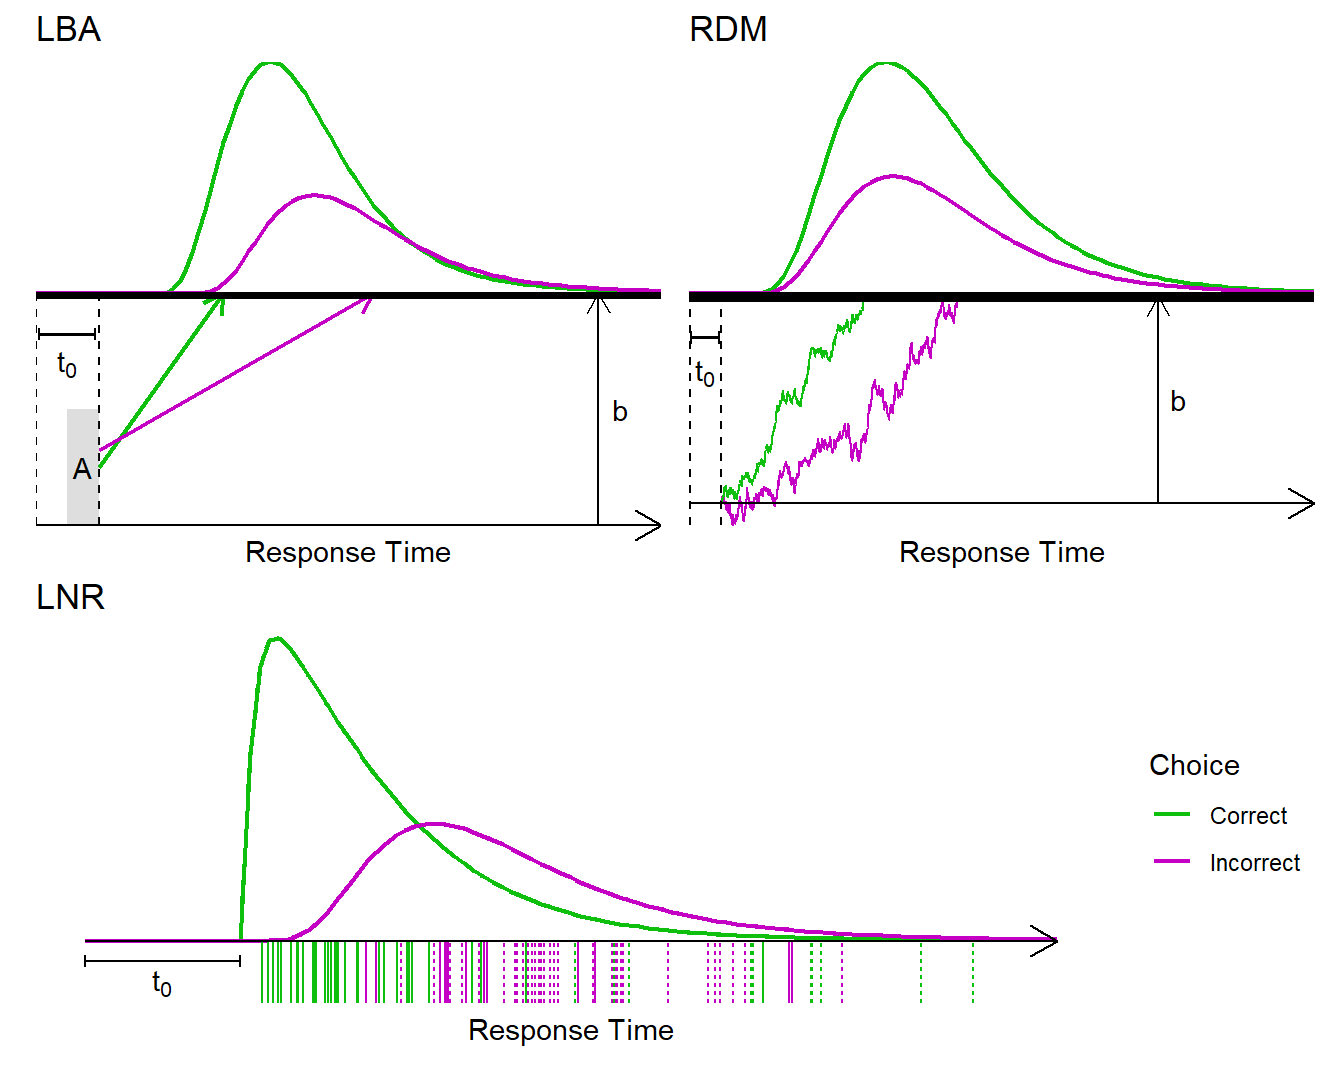

In [ ]:
# LBA ----

LBA_accumulator_plot <- ggplot(data.frame(RT = 0:2)) +
  geom_segment(aes(x = 0.2, y = 1, xend = (4 - 1) / 5 , yend = 4,
                   color = "True"),
               linewidth = 0.8,
               arrow = arrow(length = unit(3, "mm"), type = "open")) +
  geom_segment(aes(x = 0.2, y = 1.3, xend = (4 - 1.3) / 2.5 , yend = 4,
                   color = "False"),
               linewidth = 0.8,
               arrow = arrow(length = unit(3, "mm"), type = "open")) +
  theme_classic() +
  theme(plot.margin = margin(t = 0),
        axis.text = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks = element_blank(),
        axis.line.y = element_blank(),
        axis.line.x = element_line(arrow = arrow(length = unit(4, "mm"),
                                                 type = "open")),
        legend.position = "none") +
  xlab("Response Time") +
  geom_hline(yintercept = 4, linewidth = 2) +
  geom_vline(xintercept = 0.001,
             linetype = "dashed") +
  geom_vline(xintercept = 0.2,
             linetype = "dashed") +
  geom_segment(x = 0.01, xend = 0.19, y = 3.3, yend = 3.3, linewidth = 0.6) +
  geom_segment(x = 0.01, xend = 0.01, y = 3.2, yend = 3.4) +
  geom_segment(x = 0.19, xend = 0.19, y = 3.2, yend = 3.4) +
  annotate("text", x = 0.1, y  = 2.8, label = "t[0]", parse = TRUE) +
  annotate("rect", xmin = 0.1, xmax = 0.2, ymin = 0, ymax = 2, alpha = 0.2) +
  annotate("text", x = 0.15, y = 1, label = "A") +
  geom_segment(x = 1.8, xend = 1.8, y = 0, yend = 4, 
               arrow = arrow(length = unit(3, "mm"), type = "open")) +
  annotate("text", x = 1.87, y = 2, label = "b") +
  scale_x_continuous(limits=c(0, 2), expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  scale_color_manual(values = ft_colors)

LBA_density_plot <- ggplot(data.frame(RT = 0:2)) +
  stat_function(fun = dLBA,
                aes(color = "True"),
                args = list(response = 2, A=2, b= 4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                linewidth = 0.8) +
  stat_function(fun = dLBA,
                aes(color = "False"),
                args = list(response = 1, A=2, b= 4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                linewidth = 0.8) +
  theme_classic() +
  theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title.x = element_blank(),
        plot.margin = margin(b = 0),
        axis.ticks.length = unit(0, "pt"),
        axis.line.y = element_blank(),
        axis.title.y = element_blank(),
        legend.position = "none") +
  scale_x_continuous(limits=c(0, 2), expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  ggtitle("LBA") +
  scale_color_manual(values = ft_colors)

LBA_plot <- LBA_density_plot / LBA_accumulator_plot

# RDM ----
parsRDM <- c(log(3),1,.4,log(.75),log(.2))
names(parsRDM) <- c("B", "v", "v_lMd", "s_lMd", "t0")

set.seed(2)
dt = 0.001
accumulator_true <- 0
drift_true <- 1.4
s_true <- 0.75
t0 <- 0.2

while (accumulator_true[length(accumulator_true)] < 3) {
  accumulator_true <- append(accumulator_true,
                             accumulator_true[length(accumulator_true)] + 
                               dt * drift_true + rnorm(1, 0, sqrt(s_true^2 * dt)))
}

accumulator_false <- 0
drift_false <- 1
s_false <- 1

while (accumulator_false[length(accumulator_false)] < 3) {
  accumulator_false <- append(accumulator_false,
                             accumulator_false[length(accumulator_false)] + 
                               dt * drift_false + rnorm(1, 0, sqrt(s_false^2 * dt)))
}

RT_true <- t0 + seq(0, (length(accumulator_true) - 1) * dt, by = dt)
RT_false <- t0 + seq(0, (length(accumulator_false) - 1) * dt, by = dt)
RDM_dat <- data.frame(X = c(accumulator_true, accumulator_false), RT = c(RT_true, RT_false),
           Accumulator = c(rep("True", length(accumulator_true)),
                           rep("False", length(accumulator_false))))

RDM_accumulator_plot <- ggplot(RDM_dat, aes(RT, X, color = Accumulator)) + 
  geom_line() +
  theme_classic() +
  theme(plot.margin = margin(t = 0, l = 8),
        axis.text = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks = element_blank(),
        axis.line.y = element_blank(),
        axis.line.x = element_blank(),
        legend.position = "none") +
  xlab("Response Time") +
  scale_x_continuous(limits=c(0, 4), expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  geom_segment(x = 0, xend = 4, y = 0, yend = 0, color = "black",
               arrow = arrow(length = unit(4, "mm"), type = "open")) +
  geom_hline(yintercept = 3, linewidth = 2) +
  geom_vline(xintercept = 0.001,
             linetype = "dashed") +
  geom_vline(xintercept = 0.2,
             linetype = "dashed") +
  geom_segment(x = 0.01, xend = 0.19, y = 2.4, yend = 2.4, linewidth = 0.6, 
               color = "black") +
  geom_segment(x = 0.01, xend = 0.01, y = 2.3, yend = 2.5,
               color = "black") +
  geom_segment(x = 0.19, xend = 0.19, y = 2.3, yend = 2.5,
               color = "black") +
  annotate("text", x = 0.1, y  = 1.9, label = "t[0]", parse = TRUE) +
  geom_segment(x = 3, xend = 3, y = 0, yend = 3, 
               arrow = arrow(length = unit(3, "mm"), type = "open"),
               color = "black") +
  annotate("text", x = 3.13, y = 1.5, label = "b") +
  geom_hline(yintercept = 0) +
  scale_color_manual(values = ft_colors)

dRDM <- function(t, v = 1.4,  B = 3, t0 = 0.2) {
  t <- t - t0
  out <- numeric(length(t))
  out[t <= 0] <- 0
  out[t > 0] <- B/sqrt(2*pi*t[t>0]^3) * 
    exp(-(1/2) * (v * t[t>0] - B)^2 / t[t>0])
  out
}

pRDM <- function(t, v = 1,  B = 3, t0 = 0.2) {
  t <- t - t0
  out <- numeric(length(t))
  out[t <= 0] <- 0
  out[t > 0] <- pnorm((v*t[t>0] - B)/sqrt(t[t>0])) + 
                exp(2*v*B)*pnorm((-v*t[t>0] - B) / sqrt(t[t>0]))
  out
}

gRDM <- function(t, v1 = 1.4, v2 = 1,  B = 3, t0 = 0.2) {
  dRDM(t, v1, B, t0) * (1 - pRDM(t, v2, B, t0))
}

RDM_density_plot <- ggplot(data.frame(RT = 0:6)) +
  stat_function(fun = gRDM,
                args = list(v1 = drift_true, v2 = drift_false,  B = 3, t0 = t0),
                aes(color = "True"),
                linewidth = .8) +
  stat_function(fun = gRDM,
                args = list(v1 = drift_false, v2 = drift_true,  B = 3, t0 = t0),
                aes(color = "False"),
                linewidth = .8) + 
  theme_classic() +
  theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title.x = element_blank(),
        plot.margin = margin(b = 0),
        axis.ticks.length = unit(0, "pt"),
        axis.line.y = element_blank(),
        axis.title.y = element_blank(),
        legend.position = "none") +
  scale_x_continuous(limits=c(0, 5), expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  ggtitle("RDM") +
  scale_color_manual(values = ft_colors)


RDM_plot <- RDM_density_plot / RDM_accumulator_plot

# LNR ----

parsLNR <- c(log(.75),log(.65),log(.5),log(.8),log(.4))
names(parsLNR) <- c("m", "m_lMd", "s", "s_lMd", "t0")

LNR_true <- function(x){
  x <- x - 0.4
  dlnorm(x, log(0.75) + log(0.65), 0.5 + 0.8) * 
    (1 - plnorm(x, log(0.75), 0.5))
}

LNR_false <- function(x){
  x <- x - 0.4
  dlnorm(x, log(0.75), 0.5) * (1 - plnorm(x, log(0.75) + log(0.65), 0.5 + 0.8))
}

set.seed(1312)
sample_true <- rlnorm(50,  log(0.75) + log(0.65), 0.5 + 0.8)
sample_false <- rlnorm(50,  log(0.75), 0.5)
LNR_sample <- data.frame(RT = c(sample_true, sample_false) + 0.4, 
                         Choice = rep(c("Correct", "Incorrect"), each = 50),
                         Won = c(sample_true > sample_false, sample_true < sample_false))

LNR_plot <- ggplot(LNR_sample, aes(RT, color = Choice, linetype = Won)) +
  stat_function(fun = LNR_true,
                aes(color = "Correct"),
                linewidth = 0.8) +
  stat_function(fun = LNR_false,
                aes(color = "Incorrect"),
                linewidth = 0.8) +
  geom_segment(aes(x = RT, xend = RT), y = -0.3, yend = 0) + 
  geom_segment(x = 0, xend = 2.5, y = 0, yend = 0, color = "black",
               arrow = arrow(length = unit(4, "mm"), type = "open")) +
  geom_segment(x = 0, xend = 0.4, y = -0.1, yend = -0.1, color = "black") +
  geom_segment(x = 0, xend = 0, y = -0.07, yend = -0.13, color = "black") +
  geom_segment(x = 0.4, xend = 0.4, y = -0.07, yend = -0.13, color = "black") +
  annotate("text", x = 0.2, y = -0.2, label = "t[0]", parse = T) +
  xlim(0, 2.5) +
  scale_y_continuous(limits = c(-0.3, 1.5), expand = c(0,0)) +
  ggtitle("LNR") + 
  theme_classic() +
  theme(axis.text = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks = element_blank(),
        axis.line.y = element_blank(),
        axis.line.x = element_blank()) +
  labs(y = "Response Time") +
  scale_color_manual(values = rev(ft_colors)) +
  guides(linetype = "none") +
  xlab("Response Time")

(LBA_plot | RDM_plot) / free(LNR_plot)

Each of these race models have defined probability density functions $p(t \mid \boldsymbol{\theta})$ and cumulative density functions $P(t \mid \boldsymbol{\theta})$ for the finishing time of a single accumulator. To compute the likelihood of parameter vector $\boldsymbol{\theta}$ for a trial, we can take the probability density at that trial’s RT for the parameter vector $\boldsymbol{\theta}_i$ corresponding to the choice $i$, and multiply it by the probability of the other accumulators $j$ not finishing before accumulator $i$: $$
\mathcal{L}(\boldsymbol{\theta} | t, i) = p(t \mid \boldsymbol{\theta}_{i}) \prod_{j \neq i}{1 - P(t \mid \boldsymbol{\theta}_{j})},
$$ {#eq-race-likelihood} which, as a function of $t$, is the “defective distribution” for $i$, meaning that it integrates to the probability of response $i$.

Complicating the modelling of speeded decision making, RTs and choices are often missing on certain trials due to experimental design. A researcher may want to limit slow RTs in their experiment design, for example to reduce slow type II thinking \[@dualprocess\], or to emphasise speed. Alternatively, researchers may want to remove outlying responses that cannot have come from the process of interest (e.g., a response 0.05 seconds after stimulus onset, which is too fast for a decision making process to occur).

There are two main ways to handle missing values: truncation, which discards missing values with no assumption of the underlying distribution, and censoring, which assumes the proportion of missing values to reflect the true distribution, and takes this into account in the model estimation.

Although truncation could potentially improve parameter estimates by eliminating irrelevant outliers, outlier removal often increases estimation bias by excluding extreme but valid RTs \[@miller; @ulrichmiller; @outliersRatcliff; @MLcensoring\]. When truncation is used for missing values due to response windows, this could even exclude less extreme values, leading to more estimation bias. @fig-LBAtrunc illustrates how upper truncation might distort parameter estimation in a simple two forced choice decision task with slow errors. Trials with slower accumulation rates–which tend to result in more incorrect trials–get discarded, while trials with higher accumulation rates are used to estimate the underlying parameters.

Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.
Results based on 2 accumulators/drift rates.

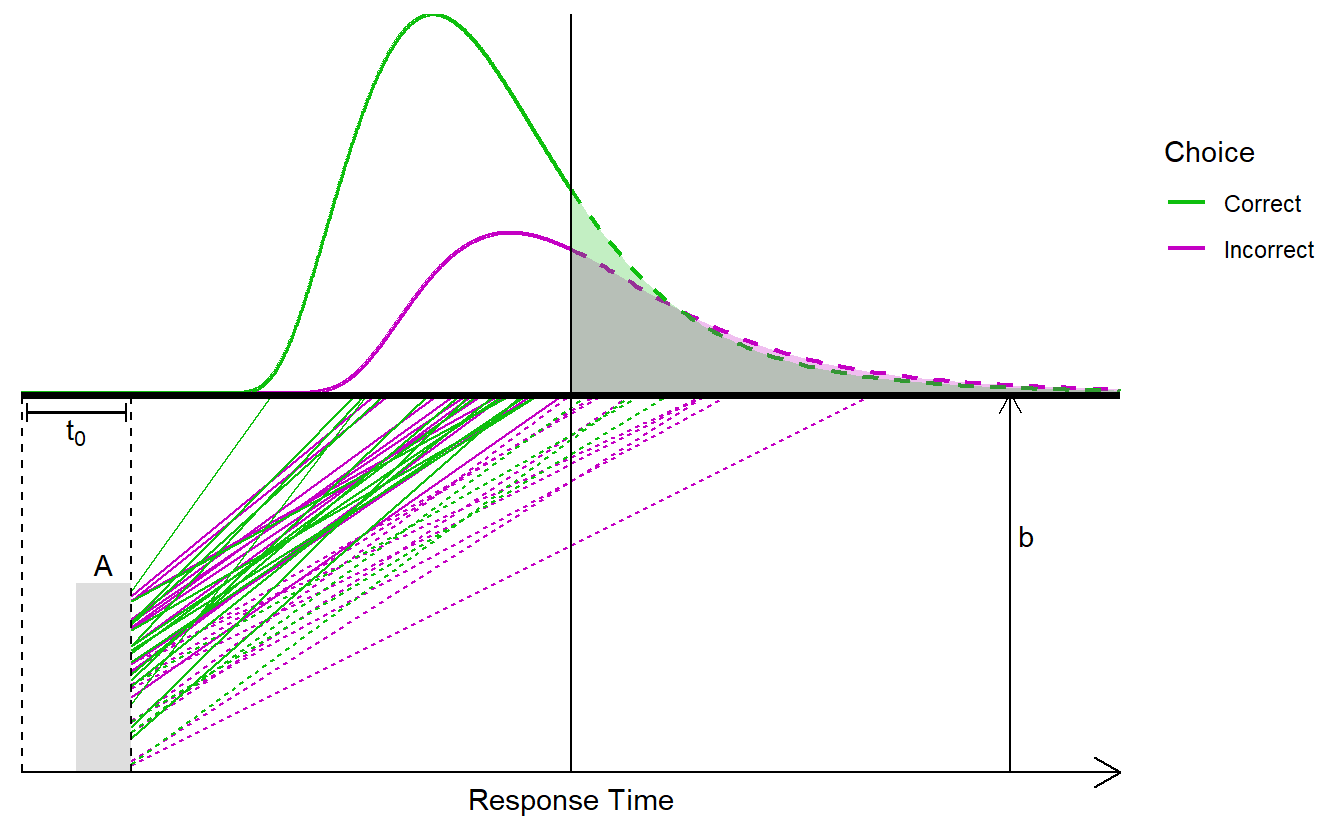

In [ ]:
LT = 0
UT = 1
l = 0.8

ntrials <- 40

set.seed(4)
slopes1 <- rnorm(ntrials,3,1)
intercepts1 <- runif(ntrials,0,2)
boundaryx1 <- (4 - intercepts1) / slopes1

slopes2 <- rnorm(ntrials,4,1.75)
intercepts2 <- runif(ntrials,0,2)
boundaryx2 <- (4 - intercepts2) / slopes2

won <- boundaryx1 < boundaryx2
late1 <- boundaryx1 > UT - 0.2
late2 <- boundaryx2 > UT - 0.2

accumulators <- data.frame(slopes1, intercepts1, boundaryx1,
                           slopes2, intercepts2, boundaryx2,
                           won, late1, late2)

LBA_densities <- ggplot(data.frame(rt = seq(0, 2, length.out = 1000)), aes(rt)) +
  stat_function(fun = dLBA,
                aes(color = "Incorrect"),
                args = list(response = 1, A=2, b= 4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(0, UT+0.0001),
                n = 1001,
                linewidth = l) +
  stat_function(fun = dLBA,
                args = list(response = 2, A=2, b= 4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(0, UT+0.0001),
                n = 1001,
                aes(color = "Correct"),
                linewidth = l) +
  stat_function(fun = dLBA,
                aes(color = "Incorrect"),
                args = list(response = 1, A=2, b=4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(UT, 2),
                linetype = "dashed",
                linewidth = l) +
  stat_function(fun = dLBA,
                args = list(response = 2, A=2, b=4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(UT, 2),
                aes(color = "Correct"),
                linetype = "dashed",
                linewidth = l) +
  stat_function(fun = dLBA,
                args = list(response = 1, A=2, b=4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(UT, 3),
                geom = "area",
                aes(fill = "Incorrect"),
                alpha = 0.25) +
  stat_function(fun = dLBA,
                args = list(response = 2, A=2, b=4, t0 = .2, mean_v=c(3,4), sd_v=c(1,1.75)),
                xlim = c(UT, 2),
                geom = "area",
                aes(fill = "Correct"),
                alpha = 0.25) +
  geom_vline(xintercept = UT) + 
  theme_classic() +
  theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title.x = element_blank(),
        plot.margin = margin(b = 0),
        axis.ticks.length = unit(0, "pt"),
        axis.line.y = element_blank(),
        axis.title.y = element_blank()) +
  scale_x_continuous(limits=c(0, 2), expand = c(0, 0)) +
  scale_y_continuous(expand = c(0, 0)) +
  guides(fill = "none") +
  labs(color = "Choice") +
  scale_color_manual(values = rev(ft_colors)) +
  scale_fill_manual(values = rev(ft_colors))

LBA_racers <- ggplot(data.frame(rt = seq(0, 2, length.out = 1000)), aes(rt)) +
  geom_segment(data = accumulators[won,],
               aes(x = 0.2, y = intercepts1, xend = boundaryx1 + 0.2, yend = 4,
                   linetype = late1, colour = "Incorrect")) +
  geom_segment(data = accumulators[!won,],
               aes(x = 0.2, y = intercepts2, xend = boundaryx2 + 0.2, yend = 4,
                   linetype = late2, colour = "Correct")) +
  scale_x_continuous(limits=c(0, 2), expand = c(0, 0)) +
  scale_y_continuous(limits=c(0, 4), expand = c(0, 0)) +
  theme_classic() +
  geom_hline(yintercept = 4, linewidth = 2) +
  geom_vline(xintercept = UT) +
  geom_vline(xintercept = 0.001,
             linetype = "dashed") +
  geom_vline(xintercept = 0.2,
             linetype = "dashed") +
  theme(plot.margin = margin(t = 0),
        axis.text = element_blank(),
        axis.title.y = element_blank(),
        axis.ticks = element_blank(),
        axis.line.y = element_blank(),
        axis.line.x = element_line(arrow = arrow(length = unit(4, "mm"),
                                                 type = "open")),
        legend.position = "none") +
  xlab("Response Time") +
  geom_segment(x = 0.01, xend = 0.19, y = 3.8, yend = 3.8, linewidth = 0.6) +
  geom_segment(x = 0.01, xend = 0.01, y = 3.7, yend = 3.9) +
  geom_segment(x = 0.19, xend = 0.19, y = 3.7, yend = 3.9) +
  annotate("text", x = 0.1, y  = 3.6, label = "t[0]", parse = TRUE) +
  annotate("rect", xmin = 0.1, xmax = 0.2, ymin = 0, ymax = 2, alpha = 0.2) +
  annotate("text", x = 0.15, y = 2.2, label = "A") +
  geom_segment(x = 1.8, xend = 1.8, y = 0, yend = 4, 
               arrow = arrow(length = unit(3, "mm"), type = "open")) +
  annotate("text", x = 1.83, y = 2.5, label = "b") +
  scale_color_manual(values = rev(ft_colors))

LBA_densities / LBA_racers

Despite the issues, many researchers still regularly implement truncation, perhaps because of common practice, or because computing the likelihood for a censored RT requires computing the area under the curve of the likelihood function over the censored range, which can be slow to compute. For race models, this means that we integrate @eq-race-likelihood over the censored time range $R$: $$
\mathcal{L}(\boldsymbol{\theta} \mid t \in R, i) = \int_{R} p(t \mid \boldsymbol{\theta}_{i}) \prod_{j \neq i}{1 - P(t \mid \boldsymbol{\theta}_{j})} \, dt.
$$ {#eq-censoring}

@eq-censoring can also be extended to accomodate missing responses in addition to missing RTs by summing @eq-censoring for each accumulator, resulting in the total probability of any response in time range $R$. Similarly, if we censored both fast and slow responses with no distinction between the two, we can sum the integrals over the lower and the upper range. We can even combine censoring and truncation with $$
\mathcal{L}(\boldsymbol{\theta} \mid t \in R, i) \frac{\mathcal{L}(\boldsymbol{\theta} \mid 0 \leq t < \infty, i)}{\mathcal{L}(\boldsymbol{\theta} \mid t \in S, i)},
$$ {#eq-censoringandtruncation} where $S$ is the range of all untruncated values.

Although censoring has been shown to result in more accurate parameter recovery than truncation in common RT distributions \[@MLcensoring\], this has not yet been established for race models. As data are routinely censored or truncated, this study aims to compare parameter recovery for different levels of censoring and truncation for the LBA, LNR, and RDM. We will examine differences between the models in sensitivity to censoring and truncation, and to what extent different levels of censoring and/or truncation cause estimation bias and/or imprecision in designs with varying numbers of trials.

Parameter estimates are expected to deteriorate fast with increased truncation, while increased censoring is expected to result in smaller and less biased deterioration of parameter recovery. Parameter posterior distributions are expected to be overconfident for truncation, whereas posterior distributions are expected to proportionally decrease in confidence with increased censoring.

# Methods

We compared RT censoring and truncation on parameter recovery in two simulation studies. The first simulation study compared upper censoring and truncation with responses known in a large number of samples to assess asymptotic parameter identifiability. The second simulation study assessed parameter recovery on a smaller number of trials to evaluate the practical differences between censoring and truncation, comparing a larger number of missing data scenarios.

To assess parameter identifiability, we first simulated data using known parameters, which we then fit the same model to. This allows us to compare the known, “true” parameter values with our fitted parameter values. The code for all analyses and data generation are available on https://github.com/timmerj1/censoring-truncation-study-EAMs.

For both simulation studies, a simple model with two stimuli and two racers was used to generate the data. Conventional constants for the LBA’s ($s_v = 1$) and the RDM’s drift rate variance ($s = 1$) were used to generate and fit the data. Parameter values were chosen to reflect common RT and choice distributions in simple two forced choice tasks (see @tbl-pars for an overview of parameters used). For the LBA, decision thresholds were defined with $B = b - A$. As is the default in EMC2, parameters on the positive real line were log transformed. Data was generated using the `make_data` function from EMC2 \[@EMC2\].

In [ ]:
params <- data.frame(
  LBA_Param = c("$B$", "$v$", "$v_{true}$", "$A$", "$s_{v_{true}}$", "$B$"),
  LBA_Value = c(2, 3, 1, 2, 0.75, "2"),
  LNR_Param = c("$m$", "$m_{true}$", "$s$", "$s_{true}$", "$t_0$", ""),
  LNR_Value = c(0.75, 0.65, 0.5, 0.8, 0.4, ""),
  RDM_Param = c("$B$", "$v$", "$v_{true}$", "$s_{true}$", "$t_0$", ""),
  RDM_Value = c(3, 1, 4, 0.75, 0.2, "")
)

kbl(params, escape = FALSE, col.names = NULL, booktabs = TRUE) %>%
  add_header_above(rep(c("Parameter", "Value"), 3)) %>%
  add_header_above(c("LBA" = 2, "LNR" = 2, "RDM" = 2))

For the first simulation, upper censoring and truncation were compared using a large number of trials (20,000 trials) to investigate the differences between censoring and truncation without fits being affected by random error. RTs were cut off at three different levels: at 2.5%, 10%, and 30% of upper values, with cutoff points estimated in a separate simulation of 20,000 trials. Responses were not missing for any of the censored values. For each combination of model and missing level, new data was simulated, but censoring and truncation were compared on the same datasets to ensure differences cannot be caused by random sampling error.

In the second simulation, a factorial design was used to vary whether responses were known or unknown, which tail missed response times (lower, upper, or both tails), the percentage of missing responses (2%, 10%, 30%, or 50%), and whether missing responses were censored or truncated. For each condition, ten samples with a small number of trials (400 trials) were simulated and fit. Missing level cutoffs were chosen using the quantiles on a non-missing simulation with 4000 trials.

Parameter posteriors were sampled using the particle Metropolis within Gibbs (PMwG) sampler in EMC2 \[@EMC2\] using its default (standard normal) priors for non-hierarchical estimation. Three PMwG chains were sampled for each parameter, with 50 particles per parameter \[@PMwG\].

To assess parameter recovery, we used the Root Mean Squared Errors (RMSEs) between the posterior medians $\boldsymbol{\hat{\theta}}$ and the true parameters $\boldsymbol{\theta}$: $$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(\hat{\theta}_i - \theta_i)^2}}.
$$ {#eq-RMSE}

Since we used Bayesian methods, the parameter estimates are not restricted to point estimates. We will compute the quadratic Wasserstein distance between the full posterior $P$ samples $X_1,...,X_n$ and Dirac point mass distribution $\delta_{\boldsymbol{\theta}}$ at the true parameters $\boldsymbol{\theta}$: $$
W_2(\delta_{\boldsymbol{\theta}}, P) = \sqrt{\frac{1}{n} \sum_{i=1}^{n}{\|X_i - \boldsymbol{\theta}\|^2}}.
$$ {#eq-Wasserstein} The Wasserstein distance was taken for the full model using the Euclidean distance, as well as for the separate parameters with unidimensional distance. The quadratic Wasserstein distance simplifies to the RMSE if point estimates were used. Moreover, the quadratic Wasserstein over a single dimension becomes an unbiased estimate of the standard deviation when $\theta$ is the mean of $P$. This makes the quadratic Wasserstein distance an interesting Bayesian alternative to the RMSE.

For completeness, additional Pearson’s correlation coefficients and mean absolute errors were computed, but since these did not differ substantially from the RMSE and $W_2$, these statistics were plotted in the appendix. All metrics in this paper and the appendix were computed using the transformations of EMC2, meaning that parameters with a “natural zero” point were log transformed to be estimated on the entire real scale.

# Results

# Study 1: Upper Censoring

@fig-RMSE-upper shows the RMSE between the true parameter values and the medians of the posterior distribution for each fit. As expected, both distance measures RMSE and $W_2$ increase with an increase of percentage missing for truncation. For censoring, the distance measures stay closer to 0 and do not clearly increase when data is censored rather than truncated. This indicates that censoring did improve the parameter recovery in an asymptotic fit as expected. The only case where censoring does not seem to outperform truncation is for the RDM, where 2.5% truncation did not perform worse than 2.5% censoring. With higher missing percentages, censoring still outperformed truncation for the RDM.

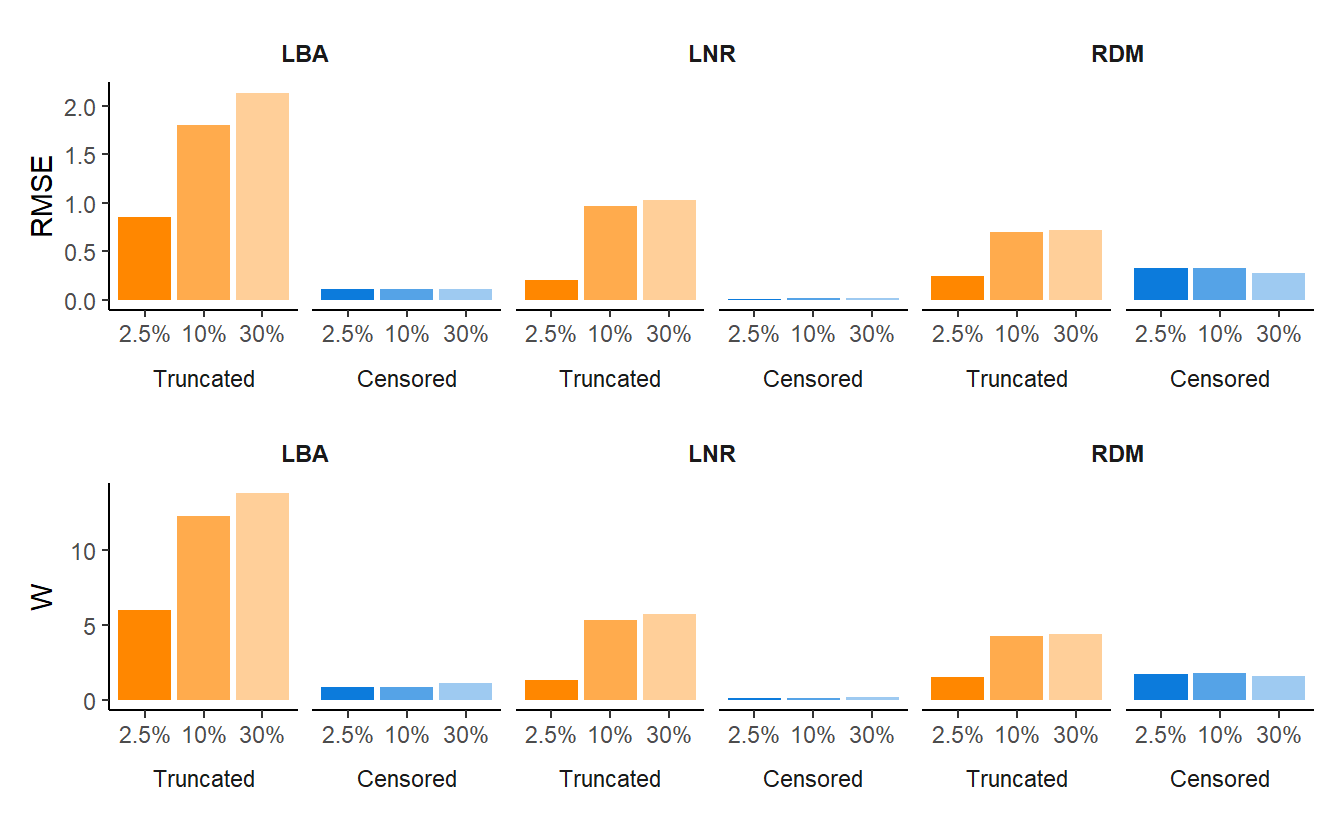

In [ ]:
RMSE_upper_plot <- EMCs_upper %>%
    ggplot(aes(Missing, RMSE, fill = Censoring, alpha = Missing)) +
    facet_nested( ~ Model + Censoring, switch = "x",
                  strip = strip_split(position = c("top", "bottom"))) +
    geom_bar(stat = "identity") +
    labs(fill = "Method") +
    theme_classic() +
    scale_fill_manual(values = ct_colors) +
    scale_alpha_ordinal(range = c(1, 0.4)) +
    theme(strip.placement = "outside",
          strip.background = element_blank(),
          axis.title.x = element_blank(),
          legend.position = "none",
          strip.text.x.top = element_text(face = "bold"))

Wasserstein_upper_plot <- Wasserstein_upper %>%
    ggplot(aes(Missing, W, fill = Censoring, alpha = Missing)) +
    facet_nested( ~ Model + Censoring, switch = "x",
                  strip = strip_split(position = c("top", "bottom"))) +
    geom_bar(stat = "identity") +
    labs(fill = "Method") +
    theme_classic() +
    scale_fill_manual(values = ct_colors) +
    scale_alpha_ordinal(range = c(1, 0.4)) +
    theme(strip.placement = "outside",
          strip.background = element_blank(),
          axis.title.x = element_blank(),
          legend.position = "none",
          strip.text.x.top = element_text(face = "bold"))

RMSE_upper_plot / Wasserstein_upper_plot

Looking at the credible intervals for each parameter in @fig-upper-censoring-recoveries, the generally higher RMSE for RDMs is explained by a general tendency for $B$ and $v$ to be overestimated, while $v_{win}$ and $t_0$ are underestimated. Overall, these parameters still seem to be recovered better with censoring than with truncation, except that $t_0$ and $s_{win}$ were recovered slightly better for truncation at a low percentage in this simulation. For the other models, censoring clearly performs better than truncation, with true parameters included by most credible intervals for censoring, while most truncation credible intervals exclude the true parameters. The main exception to this is the $s_{win}$ parameter for the LNR, where the credible interval for 30% censoring does not include the true parameter value.

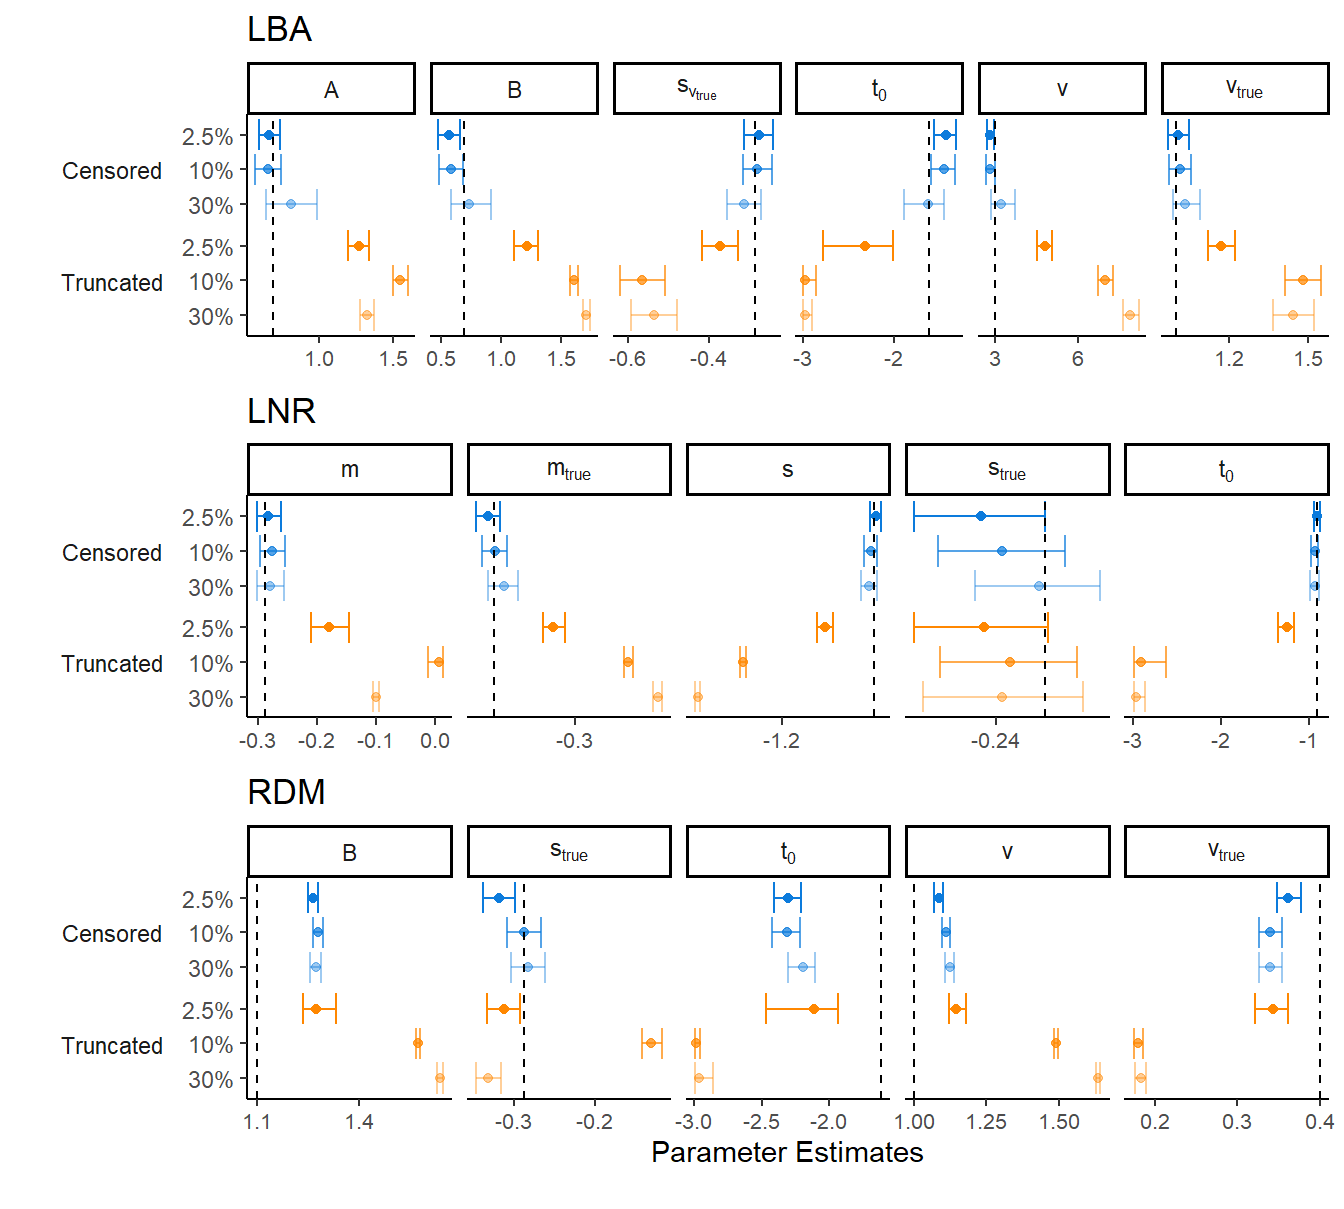

In [ ]:
LBA_upper_CI <- parameters_CI_upper %>%
  filter(Model == "LBA") %>%
  ggplot(aes(`50%`, Missing, color = Censoring, alpha = Missing)) +
  geom_point() +
  geom_errorbarh(aes(xmin = `2.5%`, xmax = `97.5%`)) +
  facet_grid(Censoring ~ Parameter, scale = "free_x",
             labeller = labeller(.default = label_parsed,
                                 Parameter = parlabeller),
             switch = "y") +
  xlab("Parameter Estimates") + 
  ylab("") +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() +
  ggtitle("LBA") +
  scale_y_discrete(limits=rev) +
  scale_color_manual(values = rev(ct_colors)) +
  theme(strip.text.y.left = element_text(angle = 0),
        strip.background.y = element_blank(),
        strip.placement = "outside",
        legend.position = "none",
        panel.spacing.y = unit(0, "lines"),
        plot.margin = margin(l = 0, b = 10),
        axis.text.x = element_text(size = 8)) +
  scale_alpha_ordinal(range = c(1, 0.4)) +
  scale_x_continuous(n.breaks = 3)
  

LNR_upper_CI <- parameters_CI_upper %>%
  filter(Model == "LNR") %>%
  ggplot(aes(`50%`, Missing, color = Censoring, alpha = Missing)) +
  geom_point() +
  geom_errorbarh(aes(xmin = `2.5%`, xmax = `97.5%`)) +
  facet_grid(Censoring ~ Parameter, scale = "free_x",
             labeller = labeller(.default = label_parsed,
                                 Parameter = parlabeller),
             switch = "y") +
  xlab("Parameter Estimates") + 
  ylab("") +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() +
  ggtitle("LNR") +
  scale_y_discrete(limits=rev) +
  scale_color_manual(values = rev(ct_colors)) +
  theme(strip.text.y.left = element_text(angle = 0),
        strip.background.y = element_blank(),
        strip.placement = "outside",
        legend.position = "none",
        panel.spacing.y = unit(0, "lines"),
        plot.margin = margin(l = 0, b = 10),
        axis.text.x = element_text(size = 8)) +
  scale_alpha_ordinal(range = c(1, 0.4)) +
  scale_x_continuous(n.breaks = 3)

RDM_upper_CI <- parameters_CI_upper %>%
  filter(Model == "RDM") %>%
  ggplot(aes(`50%`, Missing, color = Censoring, alpha = Missing)) +
  geom_point() +
  geom_errorbarh(aes(xmin = `2.5%`, xmax = `97.5%`)) +
  facet_grid(Censoring ~ Parameter, scale = "free_x",
             labeller = labeller(.default = label_parsed,
                                 Parameter = parlabeller),
             switch = "y") +
  xlab("Parameter Estimates") + 
  ylab("") +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() +
  ggtitle("RDM") +
  scale_y_discrete(limits=rev) +
  scale_color_manual(values = rev(ct_colors)) +
  theme(strip.text.y.left = element_text(angle = 0),
        strip.background.y = element_blank(),
        strip.placement = "outside",
        legend.position = "none",
        panel.spacing.y = unit(0, "lines"),
        plot.margin = margin(l = 0, b = 10),
        axis.text.x = element_text(size = 8)) +
  scale_alpha_ordinal(range = c(1, 0.4)) +
  scale_x_continuous(n.breaks = 3)

LBA_upper_CI / LNR_upper_CI / RDM_upper_CI + plot_layout(axis_titles = "collect")

Overall, these results indicate that upper censoring results in better parameter recovery than upper truncation in an asymptotic sample, i.e. with a large number of trials. This cannot yet be generalized to smaller sample sizes, as random error and parameter tradeoffs might affect parameter recovery more than censoring versus truncation does. Moreover, one might want to use lower censoring or truncation instead, or a combination of lower and upper censoring or truncation. Lastly, in this simulation the responses were known. Often censoring or truncation is implemented when there is a response time window, where neither the RTs or the choices are recorded. To account for these issues, the second simulation study takes these factors into account by using a smaller number of trials (200 instead of 1000 trials), in a $2 \times 2 \times 3 \times 3 \times 4$ design: censoring versus truncation, known versus unknown, lower versus upper versus both tails missing, LBA versus LNR versus RDM, and 2%, 10%, 30%, and 50% censoring or truncation.

# Study 2 Upper or Lower Censoring With and Without Decision

## Linear Ballistic Accumulator Model

Contrary to the first study, upper censoring with responses known did not have better parameter recovery than upper truncation for the LBA. @fig-LBA-model shows similar RMSEs and $W_2$s for all upper censoring and truncation, both getting worse with higher missing percentages. Contrary to this, fits for the lower tail clearly diverge with increasing missing percentages, with censoring outperforming truncation. Interestingly, upper tail censoring and truncation both seem to perform on par with lower tail censoring, with relatively low RMSE and $W_2$. Censoring on both tails resulted in similar RMSE and $W_2$ compared to truncation, but censored RMSEs and $W_2$s were generally lower.

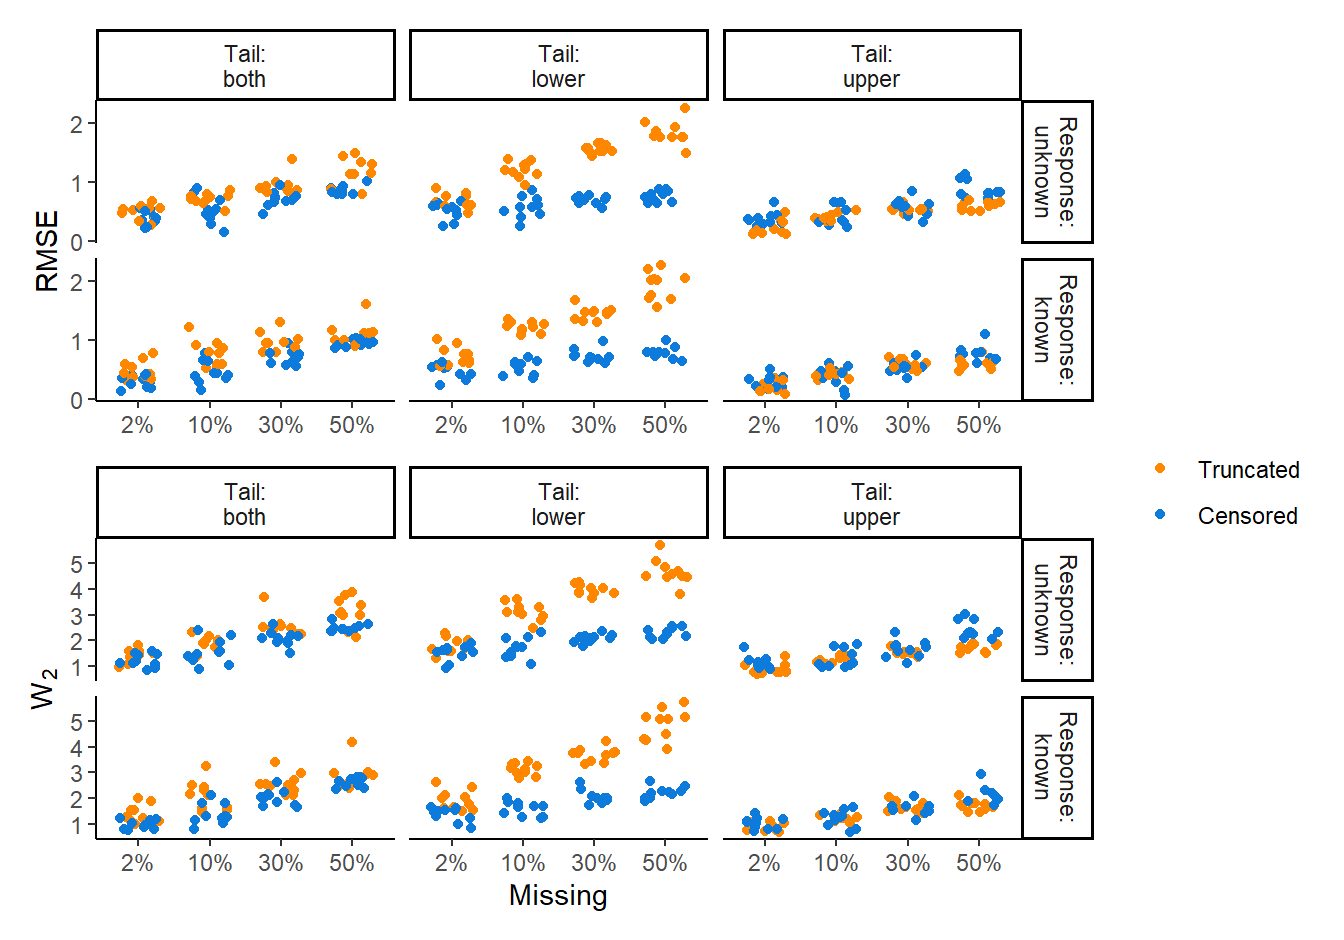

In [ ]:
RMSE_plot <- EMCs_both_RMSEs %>%
  filter(Model == "LBA") %>%
  ggplot(aes(Missing, RMSE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(color = "") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3) +
  scale_color_manual(values = ct_colors)

W_plot <- Wasserstein_both %>%
  filter(Model == "LBA" & Variable == "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(color = "") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]"))

RMSE_plot / W_plot + plot_layout(axis_titles = "collect", guides = "collect")

@fig-LBA-pars shows the $W_2$ for each LBA parameter. In accordance with @fig-LBA-model, lower censoring resulted in similar or lower $W_2$s than lower truncation. Especially the boundary $B$, non-decision time $t_0$, and mean evidence accumulation rate $v$ showed better parameter recovery for censoring compared to truncation when responses are unknown, while lower censoring with responses known improved parameter recovery for all parameters. With both tails missing, censoring showed better parameter recovery than truncation for most parameters, but worse recovery for starting point variability $A$ and mean evidence accumulation rate $v$, explaining the similar RMSE and $W_2$ in @fig-LBA-model. Lastly, when the upper tail was missing, truncation recovered the parameters similarly to censoring, with truncation showing better parameter recovery of starting point variability $A$.

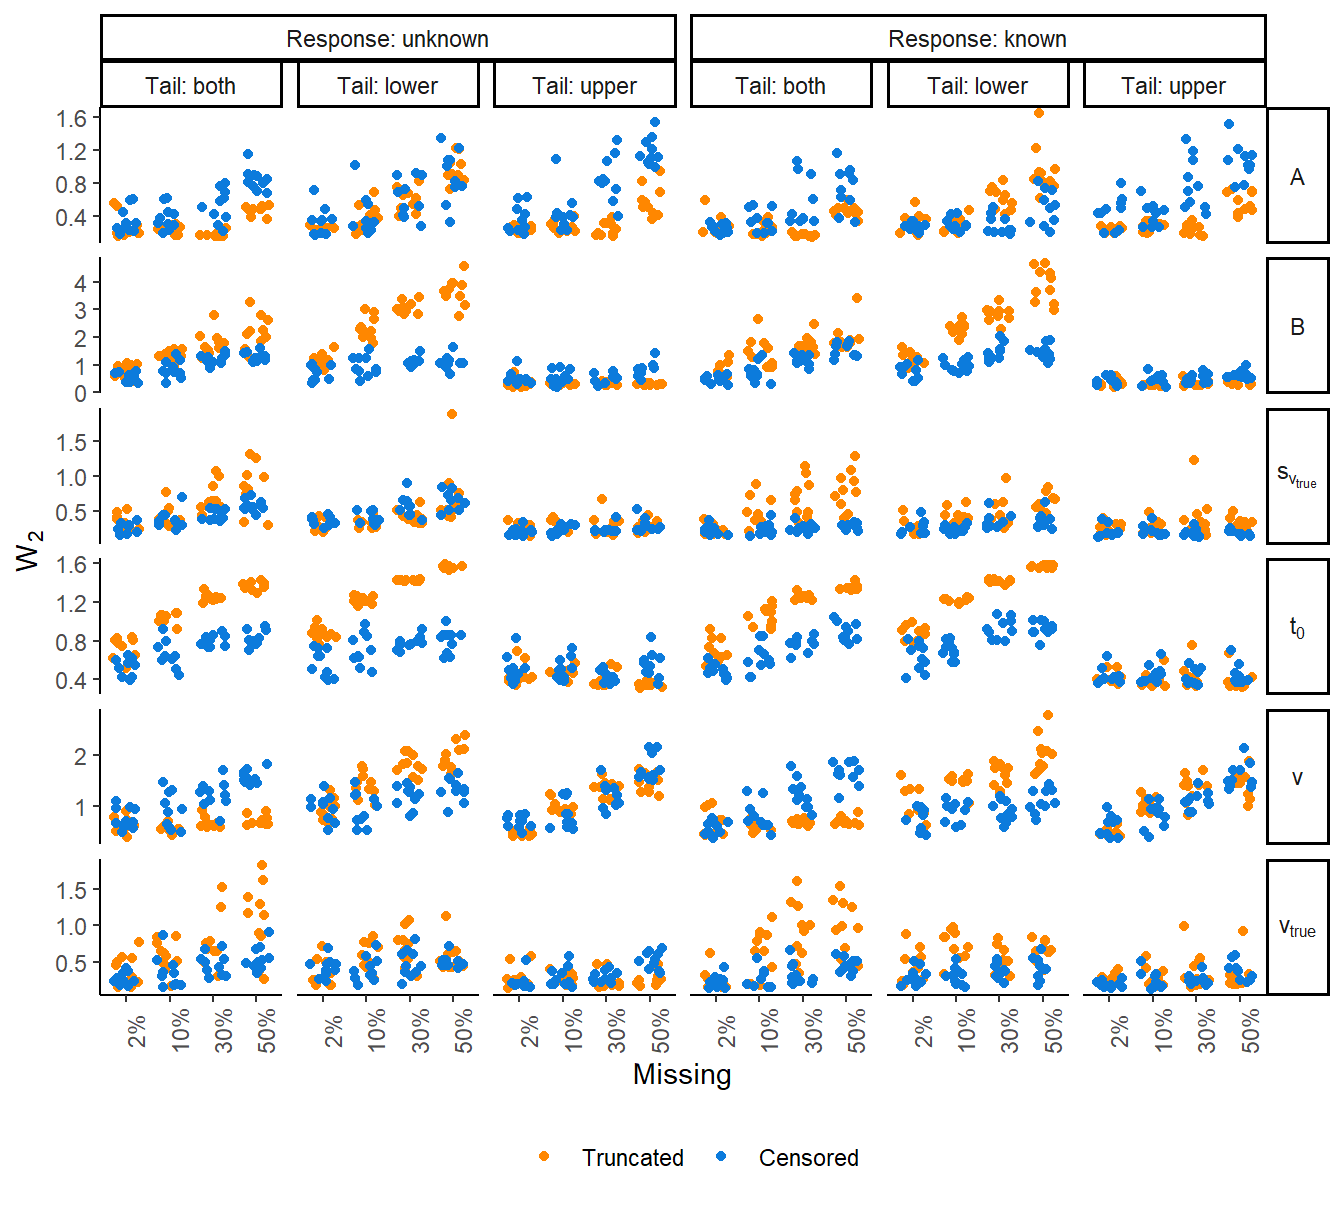

In [ ]:
Wasserstein_both %>%
  filter(Model == "LBA" & Variable != "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_nested(Variable ~ Response + Tail, scales = "free_y",
               labeller = labeller(.default = label_parsed,
                                   Response = label_both,
                                   Tail = label_both,
                                   Variable = parlabeller)) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing",
       color = "") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]")) +
  theme(strip.text.y = element_text(angle = 0),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 90))

## Log-Normal Race Model

For the LNR, both upper and lower censoring showed better parameter recovery as expected. For the lower and upper tail simulation, @fig-LNR-model shows the expected pattern of increasing RMSEs and $W_2$s for truncation while censoring RMSEs and $W_2$s remain low. Unexpectedly, missing values in both tails did not result in the same clear pattern, especially for $W_2$. This difference between RMSEs and $W_2$ indicate that although the medians of censoring posterior distributions were closer to the true parameter values, the complete posteriors had similar distances to the true parameter values for censoring compared to truncation.

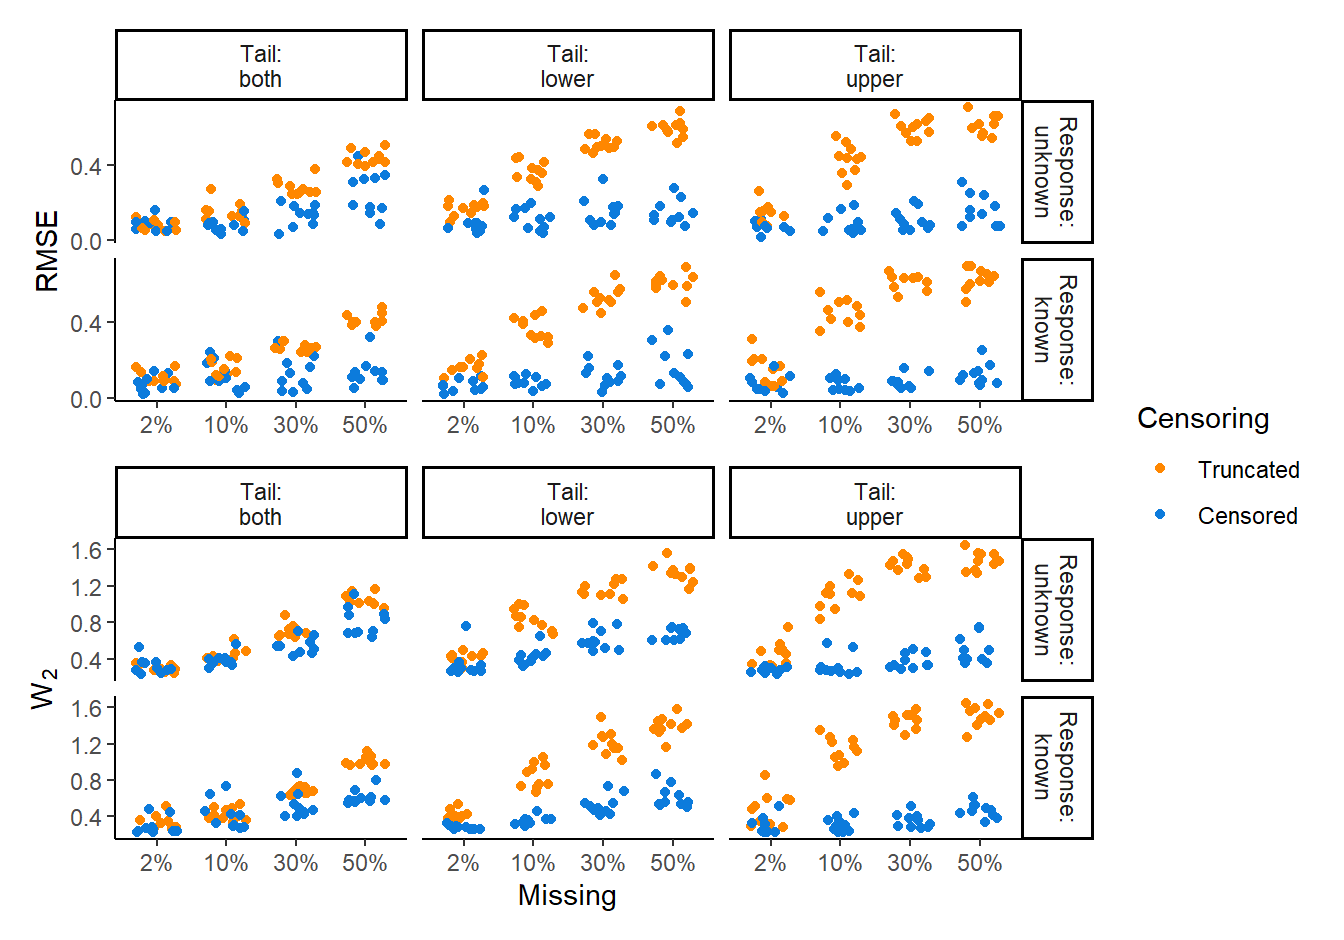

In [ ]:
RMSE_plot <- EMCs_both_RMSEs %>%
  filter(Model == "LNR") %>%
  ggplot(aes(Missing, RMSE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3) +
  scale_color_manual(values = ct_colors)

W_plot <- Wasserstein_both %>%
  filter(Model == "LNR" & Variable == "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]"))

RMSE_plot / W_plot + plot_layout(axis_titles = "collect", guides = "collect")

Looking at the parameter $W_2$s in @fig-LNR-pars, we see that lower truncation particularly deteriorated the estimates for the log-normal $\mu$ estimates $m$ and $m_{true}$, and non-decision time $t_0$ compared to lower censoring, whereas upper truncation deteriorated the estimates for log-normal $\sigma$ estimate $s$ and $t_0$ compared to upper censoring. Surprisingly, $W_2$s for $t_0$ estimates were worse for upper truncation than lower truncation, even though non-decision time is largely reflected by the minimum RT. When responses were unknown, lower and two-tailed censoring had worse parameter recovery for $s_{true}$ than truncation. Two-tailed censoring recovered $m$ and $s$ better than two-tailed truncation, but resulted in recoveries that were similar to truncation for the other parameters.

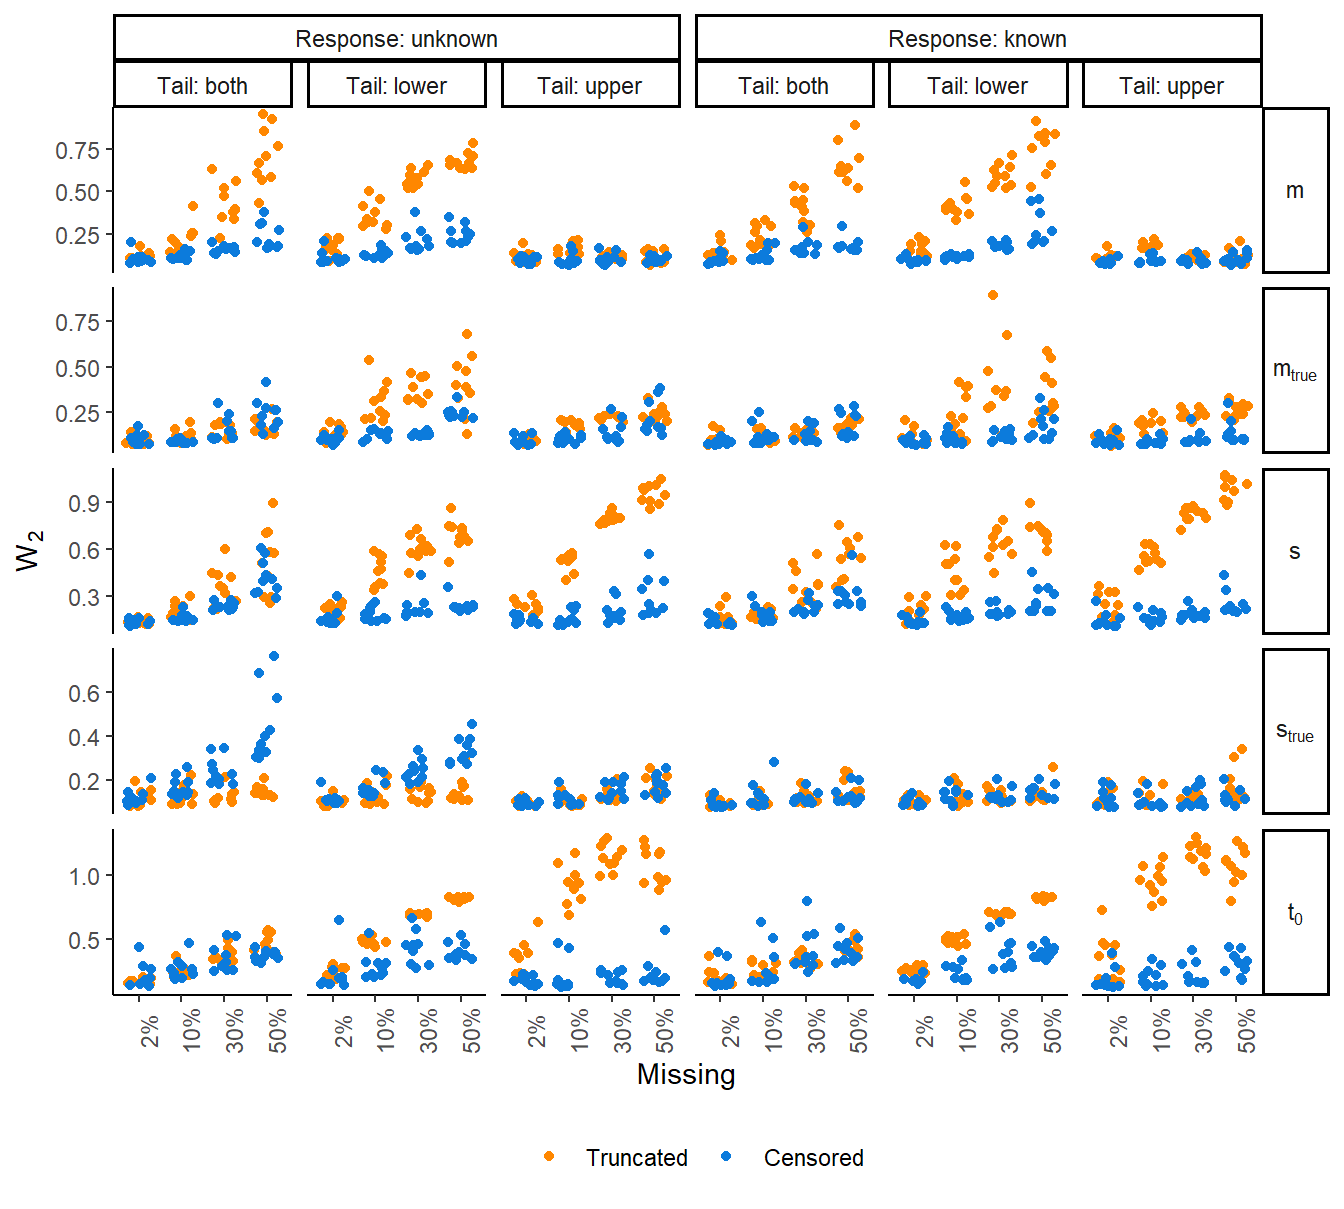

In [ ]:
Wasserstein_both %>%
  filter(Model == "LNR" & Variable != "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_nested(Variable ~ Response + Tail, scales = "free_y",
               labeller = labeller(.default = label_parsed,
                                   Response = label_both,
                                   Tail = label_both,
                                   Variable = parlabeller)) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing",
       color = "") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]")) +
  theme(strip.text.y = element_text(angle = 0),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 90))

## Racing Diffusion Model

Like the LBA, @fig-RDM-model shows higher RMSEs and $W_2$s for lower truncation compared to lower censoring, while upper and two-tailed censoring show similar, lower RMSEs and $W_2$s compared to truncation. Only when responses were known, upper tail censoring resulted in lower RMSE and $W_2$ than truncation, but without a clear separation.

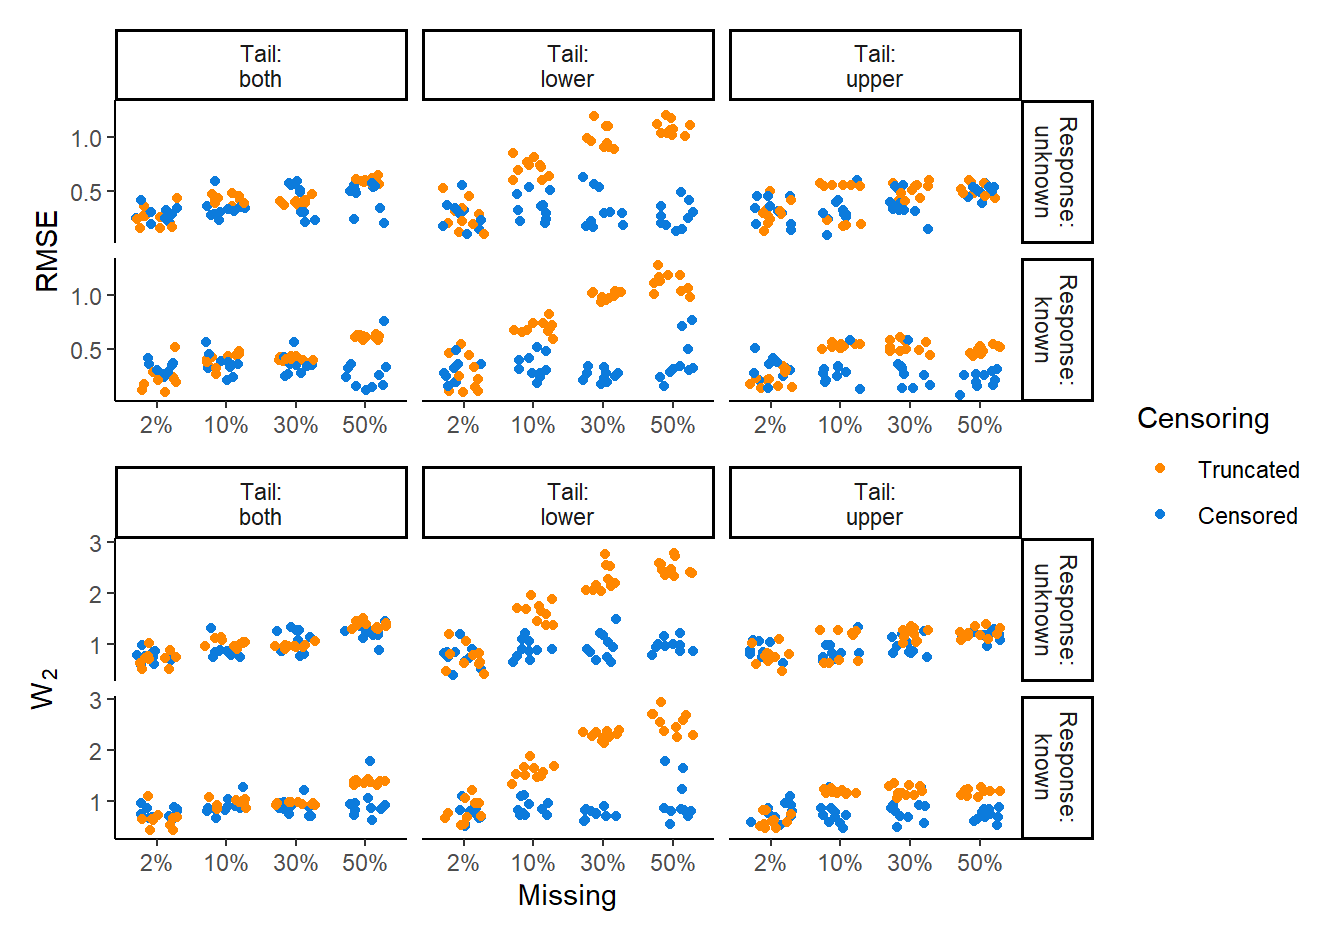

In [ ]:
RMSE_plot <- EMCs_both_RMSEs %>%
  filter(Model == "RDM") %>%
  ggplot(aes(Missing, RMSE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3) +
  scale_color_manual(values = ct_colors)

W_plot <- Wasserstein_both %>%
  filter(Model == "RDM" & Variable == "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = function(x) label_both(x, sep = ":\n")) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]"))

RMSE_plot / W_plot + plot_layout(axis_titles = "collect", guides = "collect")

The parameter $W_2$s shown in @fig-RDM-pars also showed a similar pattern to the LBA. Lower tail truncation mainly affected the boundary parameter $B$, the non-decision time $t_0$, and the drift rates $v$ and $v_{true}$ compared to lower censoring. The $W^2$s for the drift rate of the incorrect option, $v$, was increasing for truncation compared to censoring, regardless of the tail or whether responses were known. For the other parameters, upper tail and two-tailed censoring was not particularly better or worse than truncation, with an exception of the recovery of $B$ and $v_{true}$ for upper tail censoring with responses known.

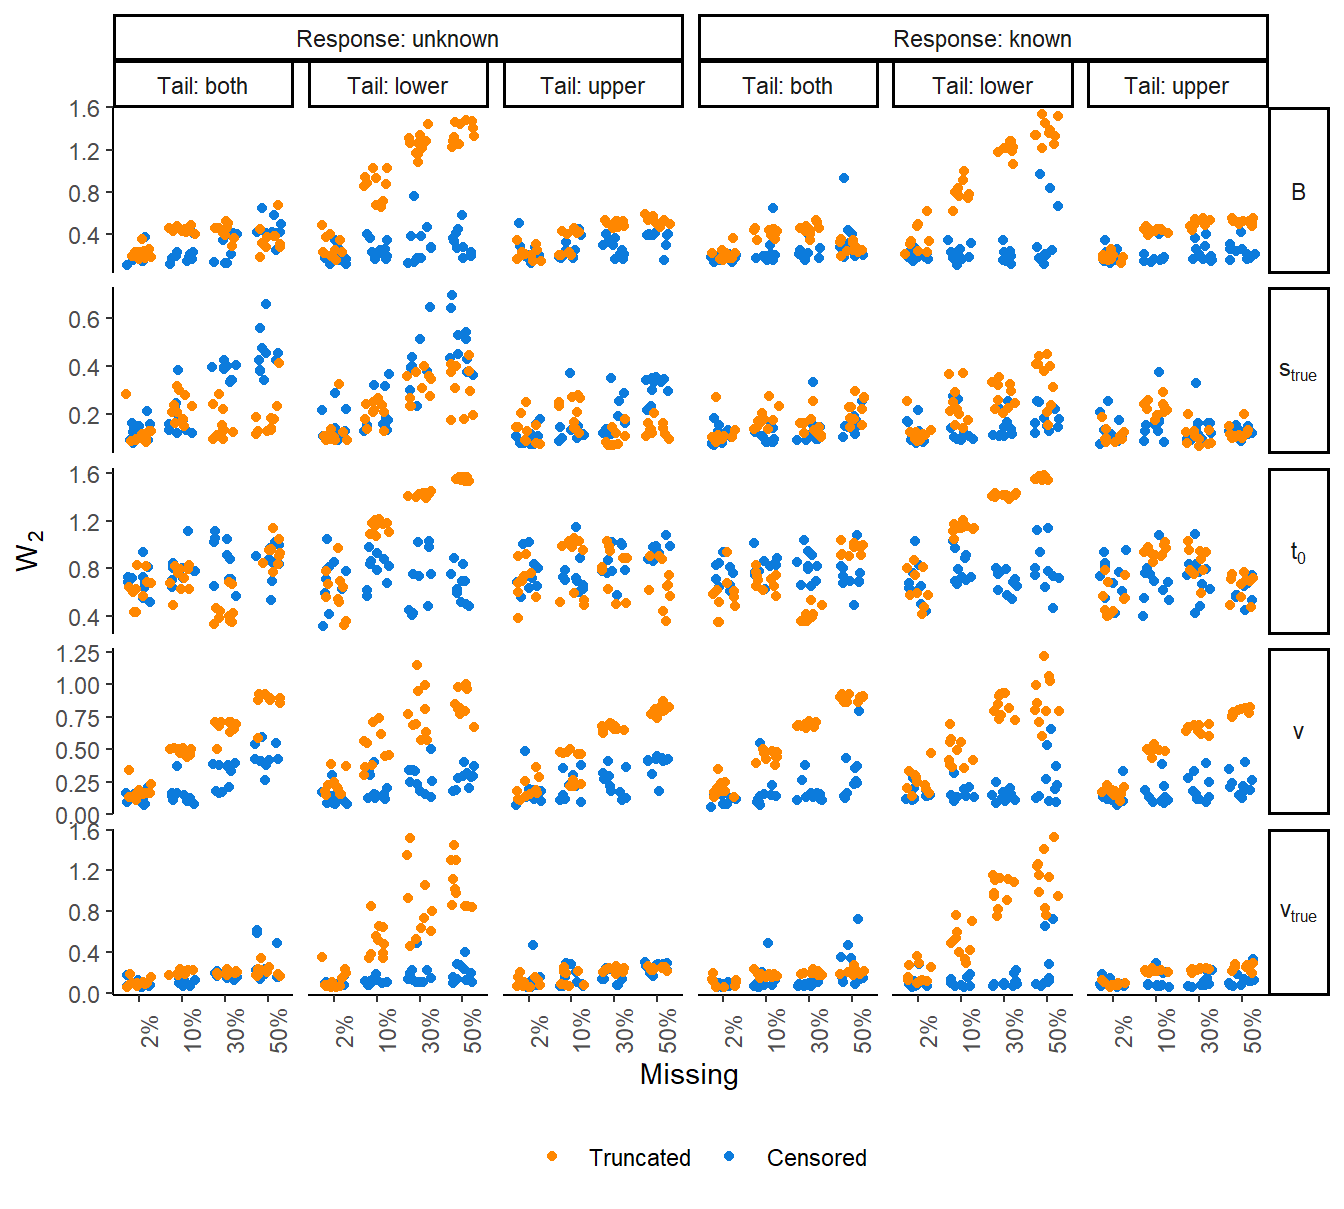

In [ ]:
Wasserstein_both %>%
  filter(Model == "RDM" & Variable != "model") %>%
  ggplot(aes(Missing, W, color = Censoring, group = Censoring)) +
  facet_nested(Variable ~ Response + Tail, scales = "free_y",
               labeller = labeller(.default = label_parsed,
                                   Response = label_both,
                                   Tail = label_both,
                                   Variable = parlabeller)) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing",
       color = "") +
  theme_classic() +
  scale_color_manual(values = ct_colors) +
  ylab(parse(text = "W[2]")) +
  theme(strip.text.y = element_text(angle = 0),
        legend.position = "bottom",
        axis.text.x = element_text(angle = 90))

# Discussion

We compared censoring and truncation for three different race models: the linear ballistic accumulator model, the log-normal race model, and the racing diffusion model. To this end, we simulated data using pre-specified parameter values, with missing data cutoffs based on quantiles. The first simulation study compared asymptotic parameter recovery upper censoring and truncation with responses known. The second simulation used several smaller datasets for each condition in a factorial design. It compared lower, upper and two-tailed censoring or truncation, with either results known or unknown.

In the first simulation, parameters were recovered well for censoring, while parameters estimated with truncation were considerably off, even at lower percentages of missingness. Only for the RDM, 2.5% truncation was on par with censoring. The RDM had worse parameter recovery than the other two models in general, with credible intervals for some parameters missing the true parameter for each level of censoring or truncation. Censoring still outperformed truncation in the RDM for higher percentages of missing RTs.

The second simulation showed that the previous results did not hold with smaller sample sizes for the LBA and RDM. However, lower truncation did result in worse parameter recovery than censoring. For the LNR, upper and lower truncation both resulted in better recovery than truncation, but two-tailed truncation was closer to censoring in terms of parameter recovery.

The results indicate that censoring improves parameter recovery asymptotically, but in smaller numbers of trials, differences between censoring and truncation can become inconsequential compared to random sampling error.

Since parameter recovery for censoring was not worse than for truncation, censoring should be preferred if parameter recovery is the only consideration. When computation time and resources are relevant factors, however, censoring might not always be worth the cost. When responses were unknown, resulting in a higher number of numerical integrals for each likelihood calculation, the PMwG sampler took more than 28 hours in an extreme case in the second simulation. In less extreme cases with responses known, this time was closer to 15 minutes.

To speed up the MCMC sampling for censoring, the likelihood function for censoring was translated from R to Rcpp. This approximately doubled the speed. In the Rcpp likelihood function, numerical integration was implemented with RcppNumerical @RcppNumerical, an Rcpp library for numerical integration and optimization. Although this results in faster likelihood estimations than with the `integrate` function in R, the computation time is still considerable. To make censoring more worthwhile, changing to a faster quadrature rule that does not have to work for complicated multimodal functions might be beneficial.

The simulations in this paper all used non-hierarchical models. Since the second simulation seems to have been more affected by random error than by truncation, future simulations might use hierarchical modeling, which is less affected by random error for single participants, but instead shrinks more extreme values to group level means \[@shrinkage\], making the inference more robust against random sampling error. Hierarchical models are increasingly used and it remains unclear how censoring and truncation affects hierarchical model estimation.

Another avenue that remains uninvestigated is how contamination ties into censoring and truncation. Since truncation can remove outliers, truncation could potentially lead to better parameter recovery than censoring would in the presence of contaminant RTs. On the other hand, MCMC methods also allow for the explicit modeling of contaminants. The likelihood function that was implemented in EMC2 allows for combinations of censoring, truncation, and explicit contaminant modeling, and future simulations could investigate how combinations of these methods might lead to better parameter recovery.

How researchers handle outliers and missing data can greatly affect the outcomes of their research. Our results suggest that ignoring values outside of a prespecified response window or outside of common outlier thresholds can bias race model estimates. Although censoring can be computationally costly, it should be the default over truncation when the objective is accurate estimation of latent cognitive parameters.



# References

# Supplementary Materials Study 1

# Supplementary Materials Study 2

## Linear Ballistic Accumulator Model

### Model Distances

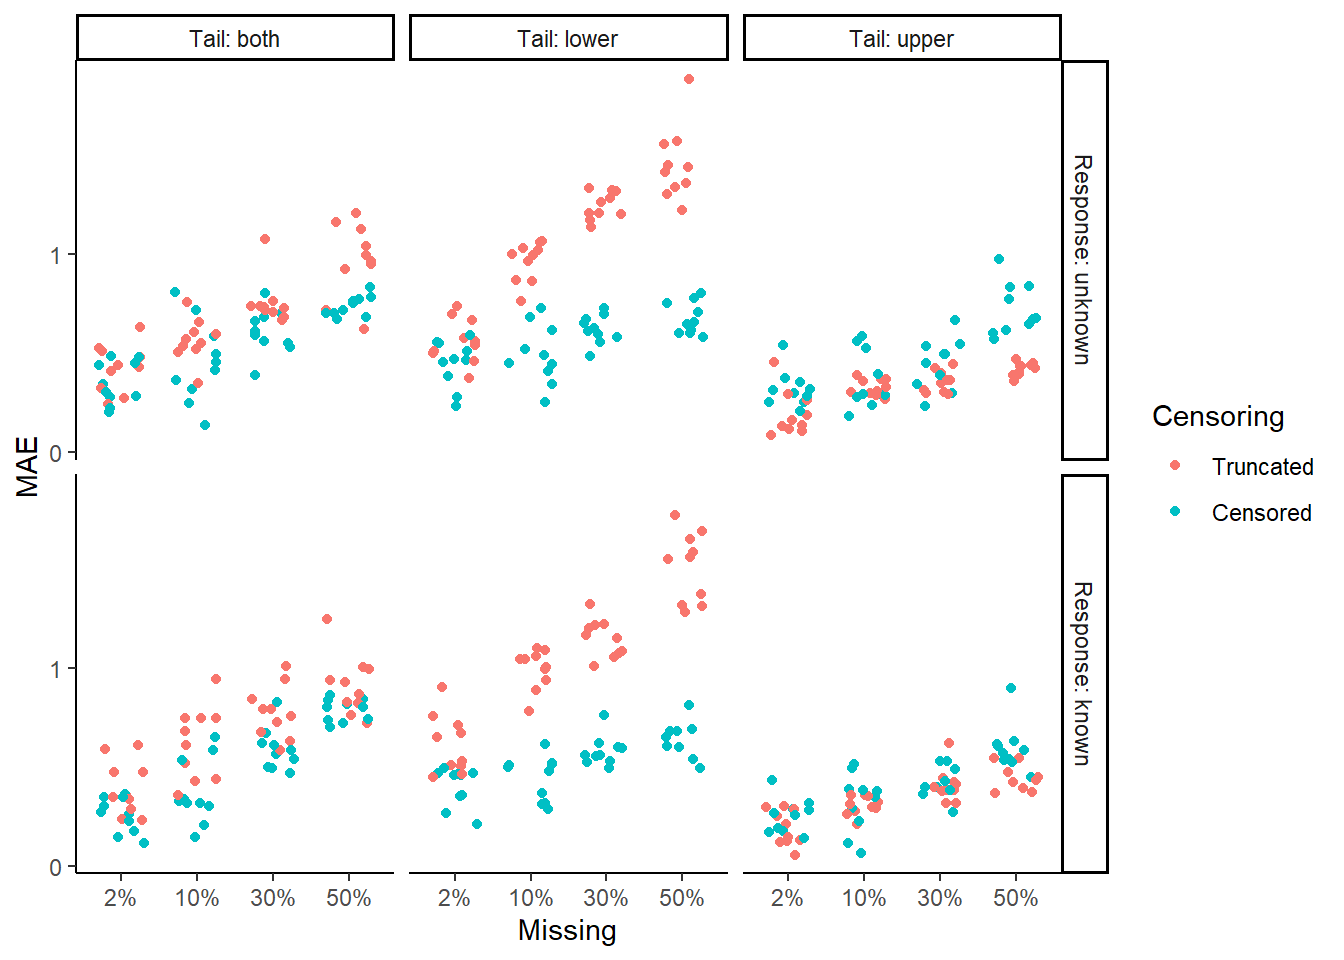

In [ ]:
EMCs_both_MAEs %>%
  filter(Model == "LBA") %>%
  ggplot(aes(Missing, MAE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

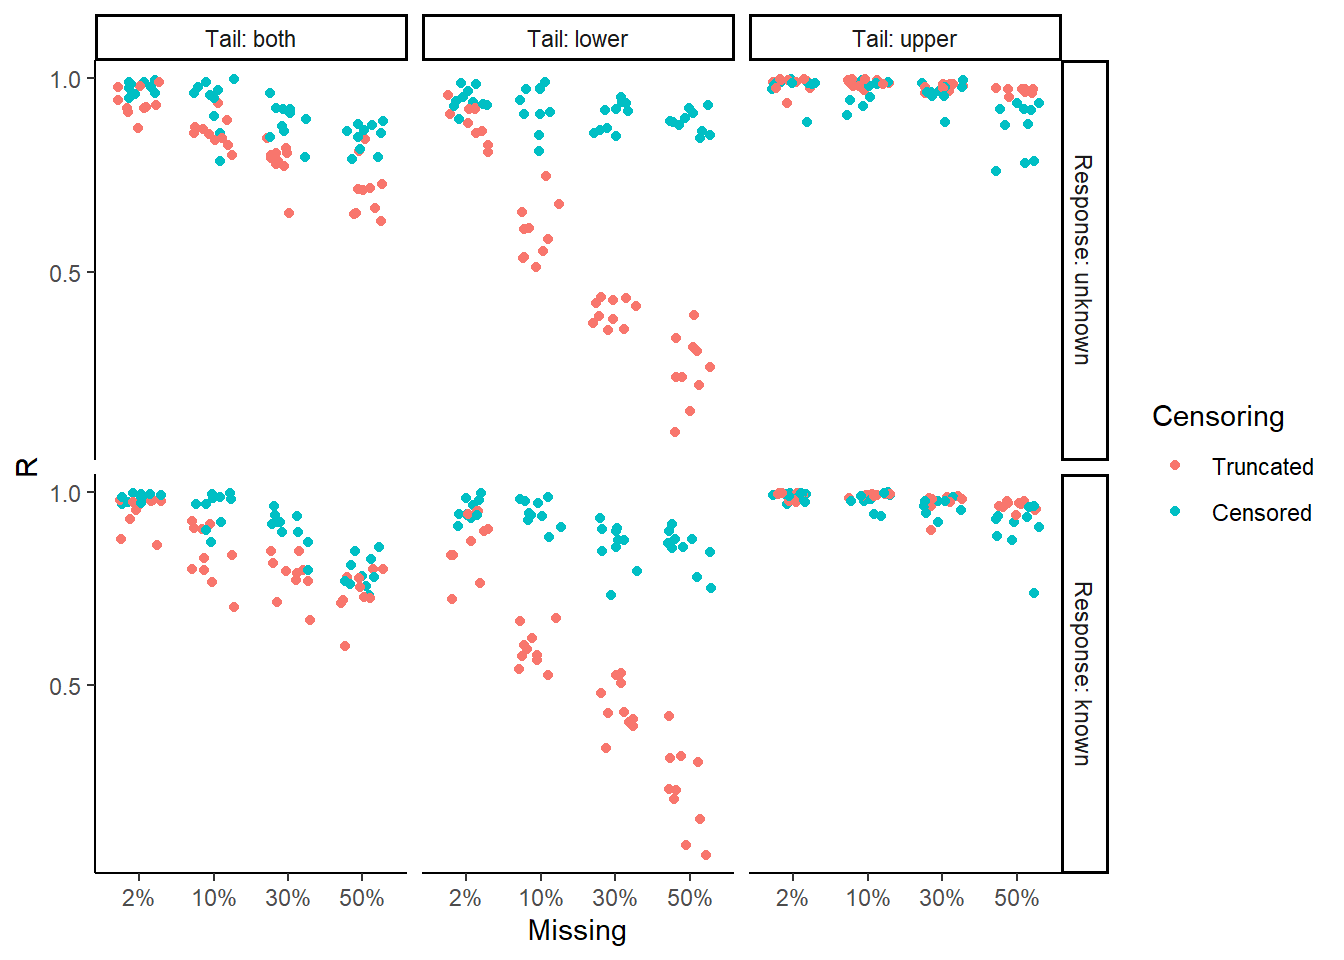

In [ ]:
EMCs_both_Rs %>%
  filter(Model == "LBA") %>%
  ggplot(aes(Missing, R, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

### Credible Intervals

#### Upper Tail

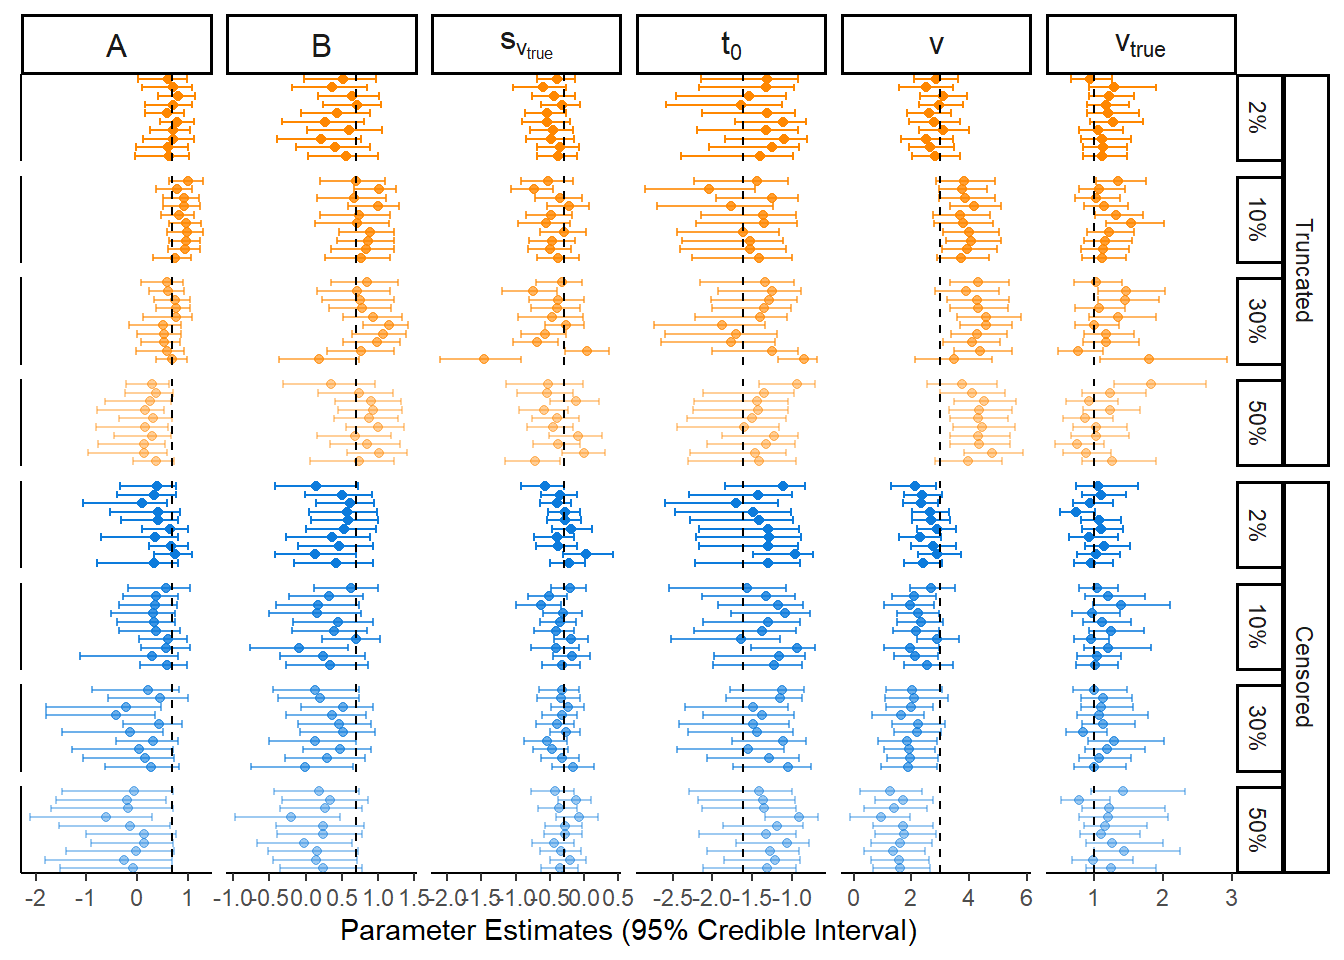

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "upper" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

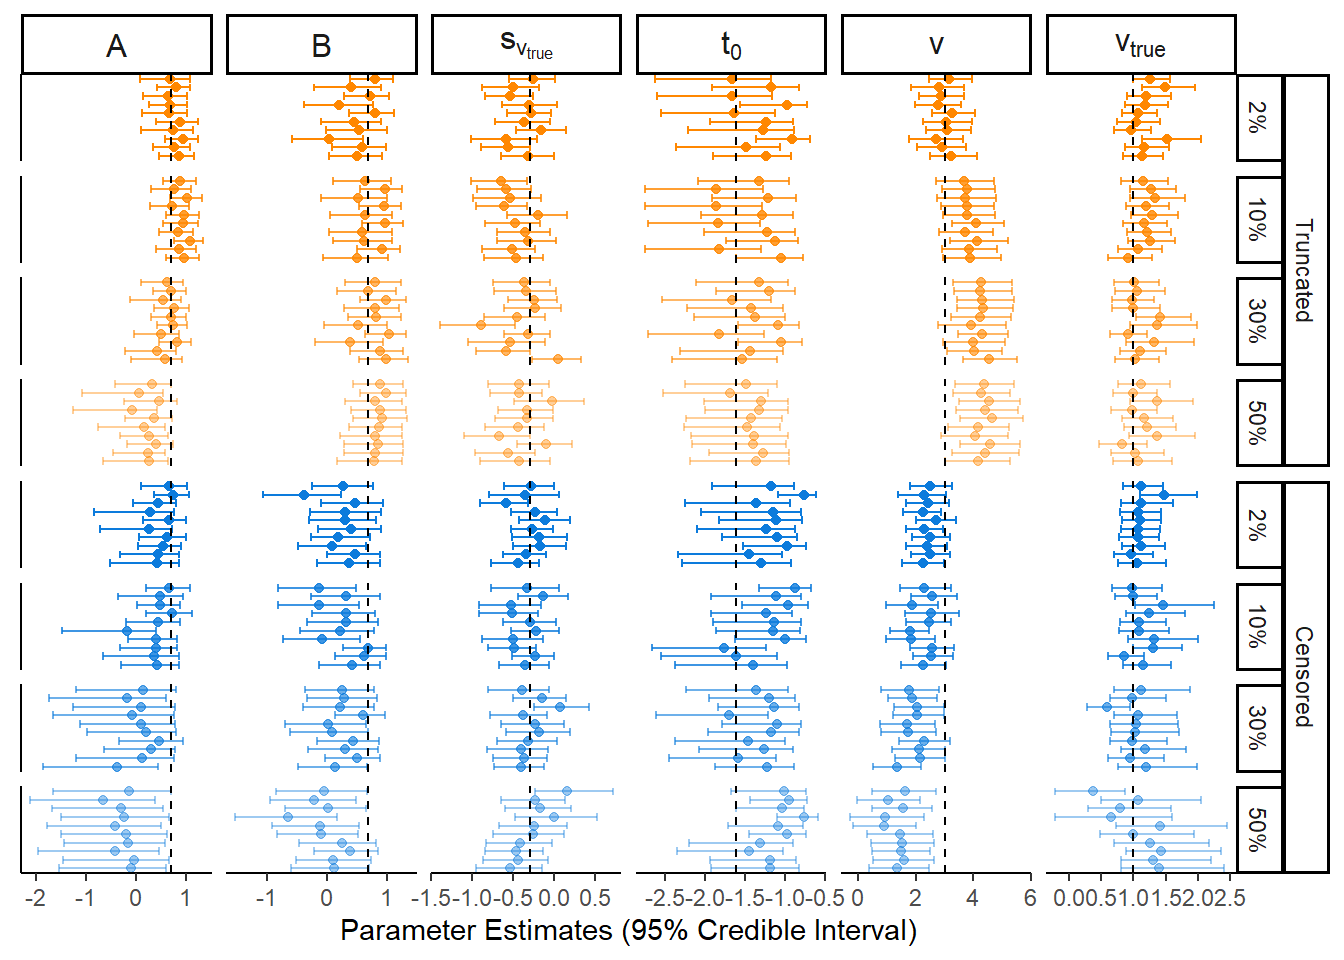

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "upper" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Lower Tail

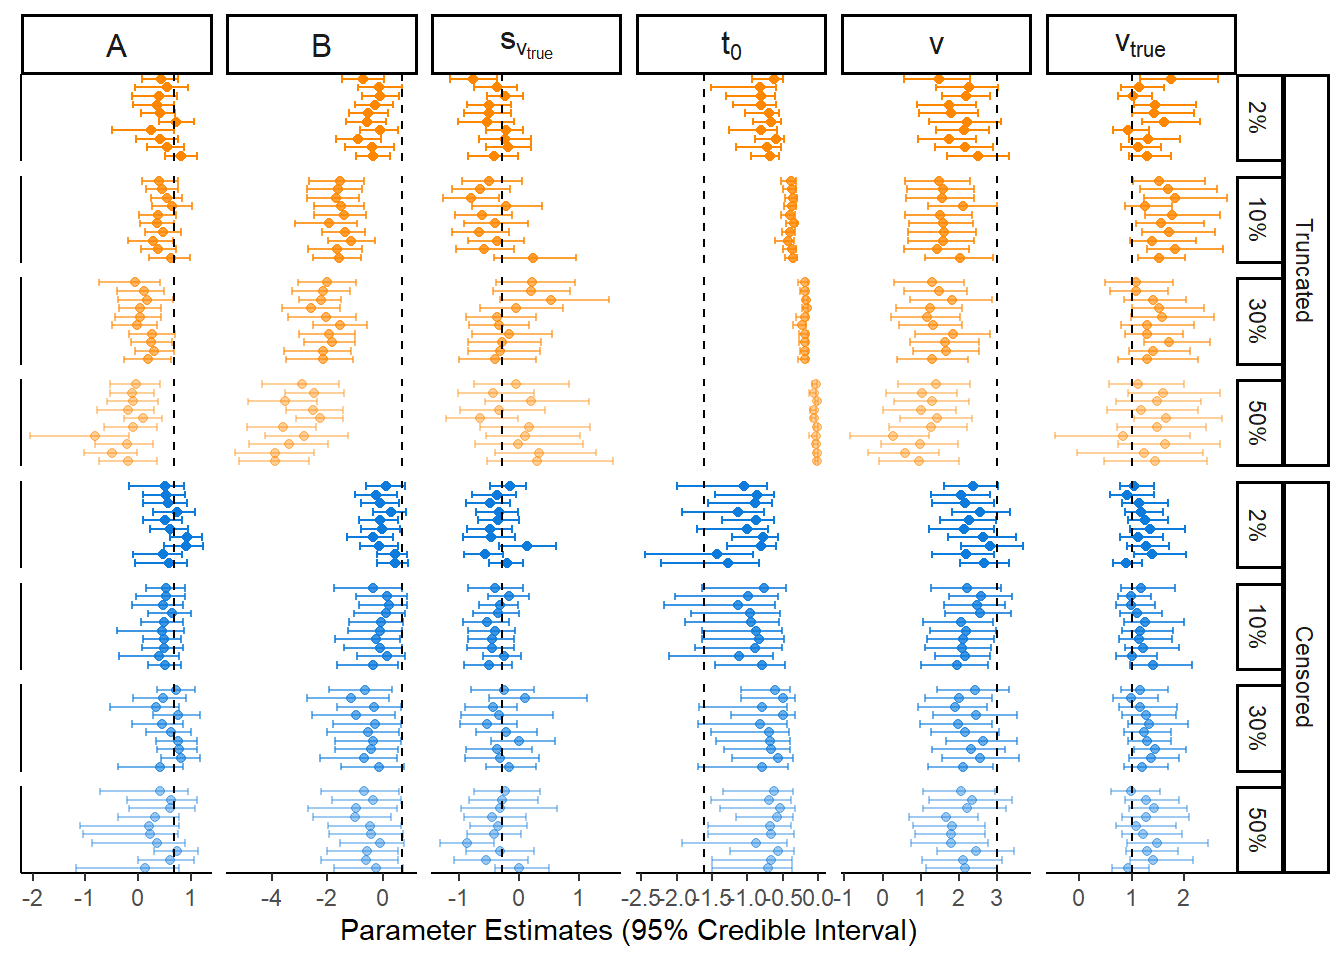

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "lower" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

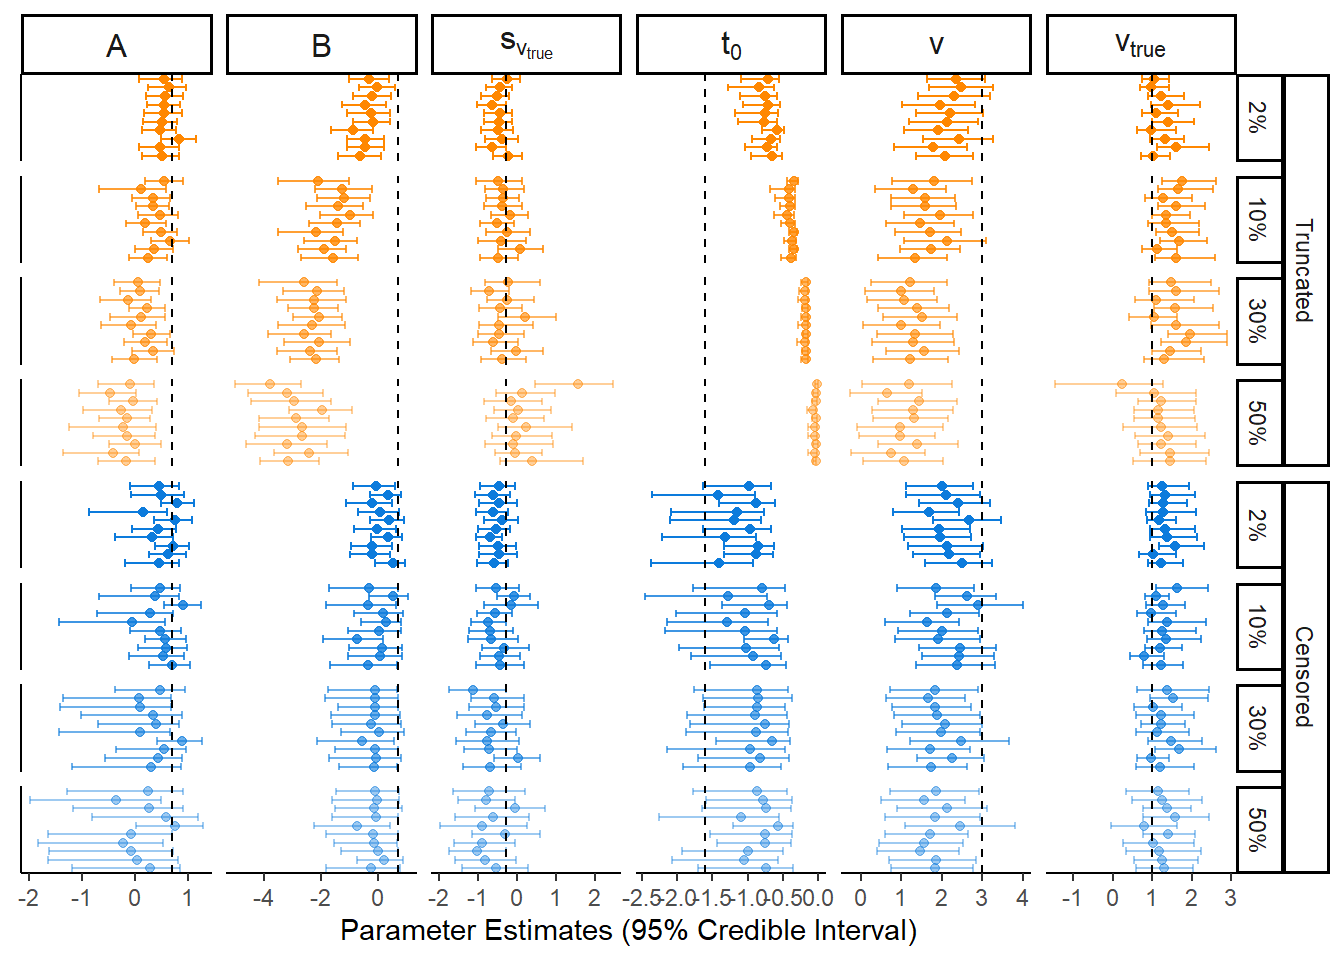

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "lower" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Both Tails

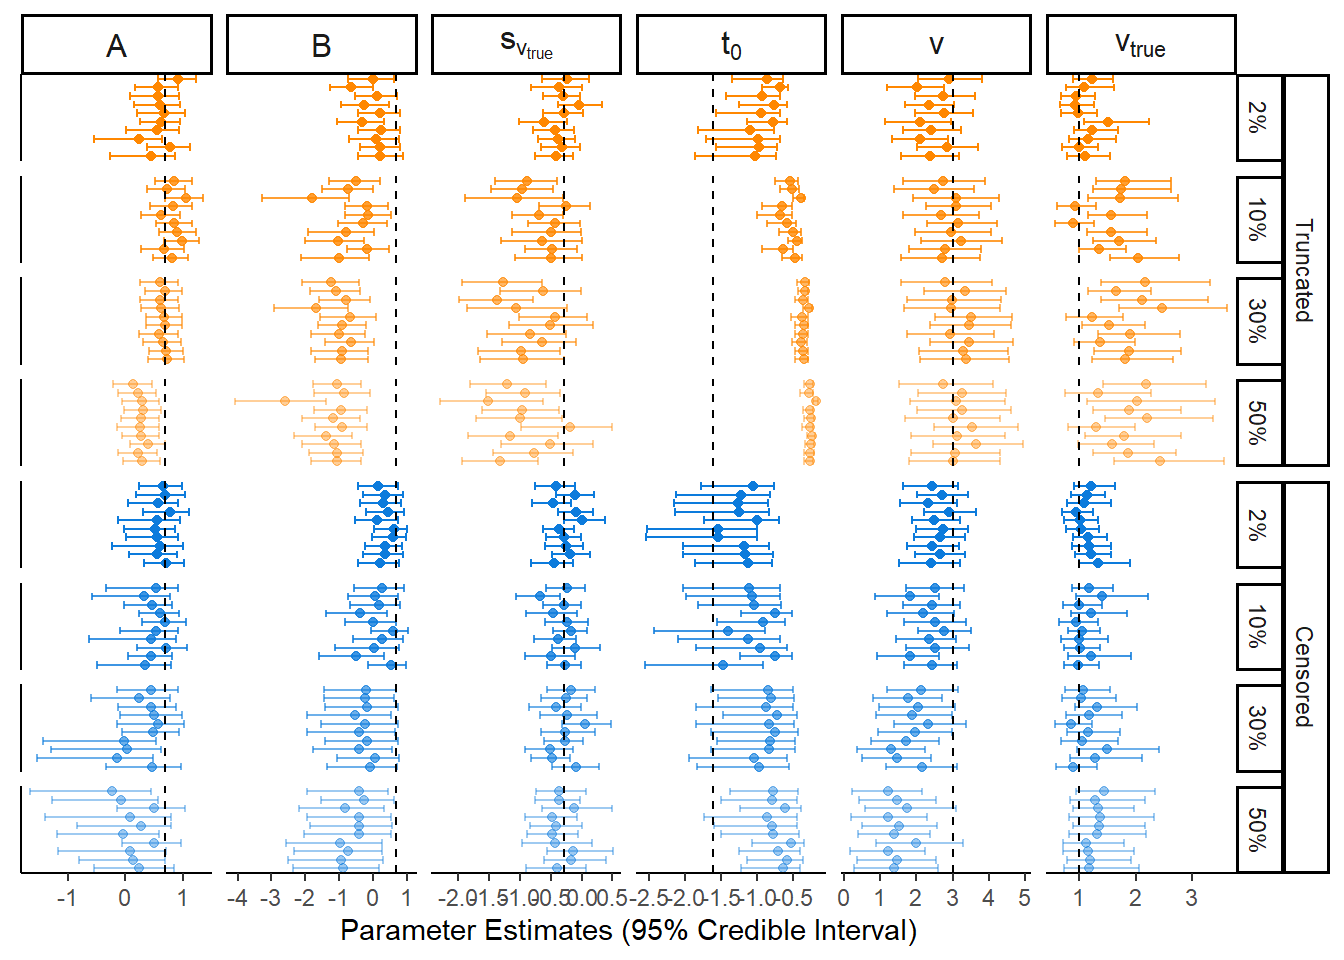

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "both" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

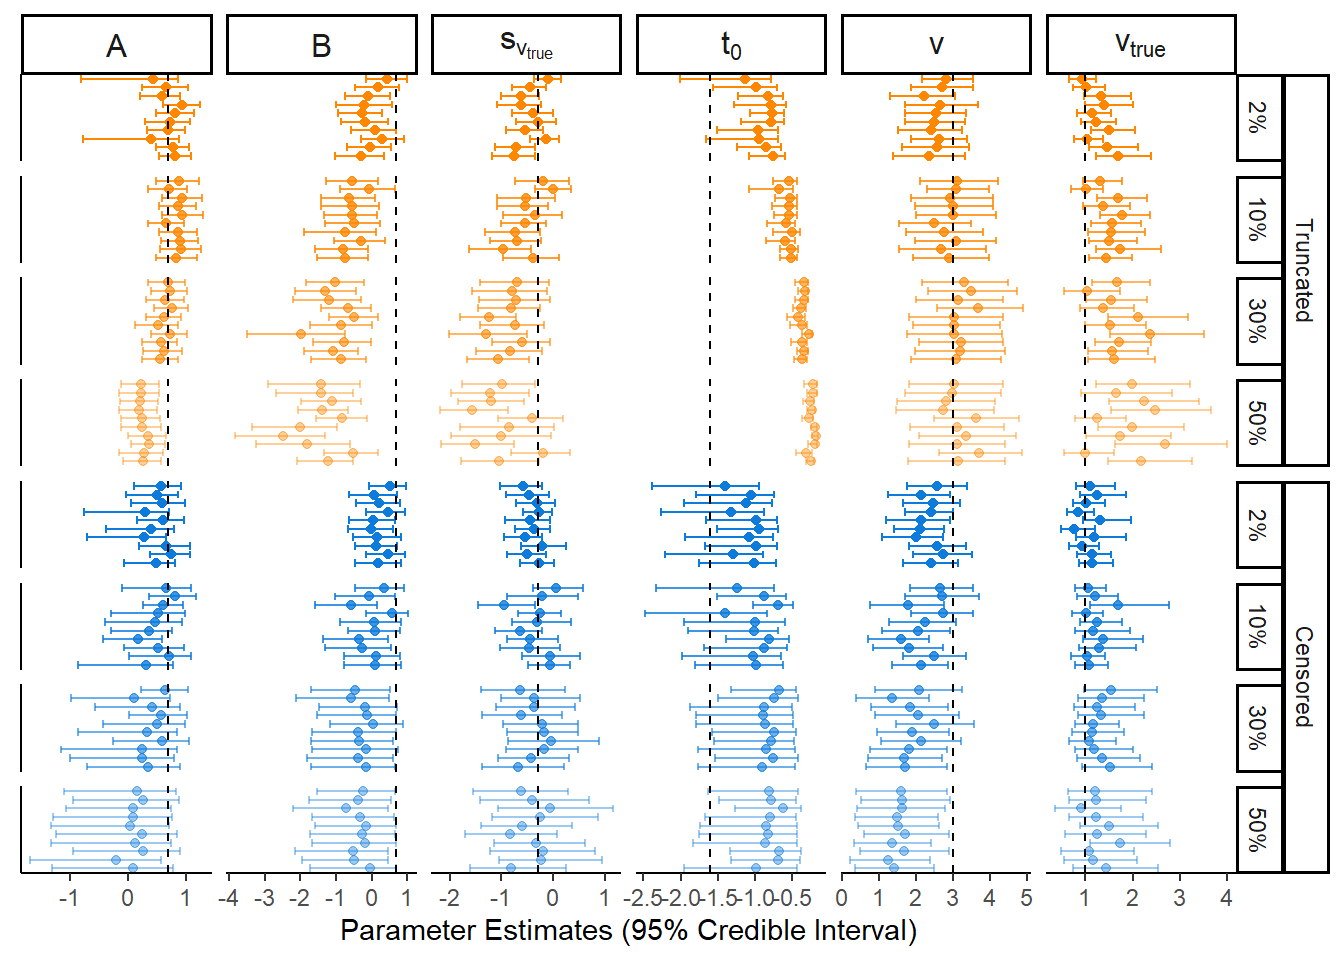

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LBA" & Tail == "both" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

## Log-Normal Race Model

### Model Distances

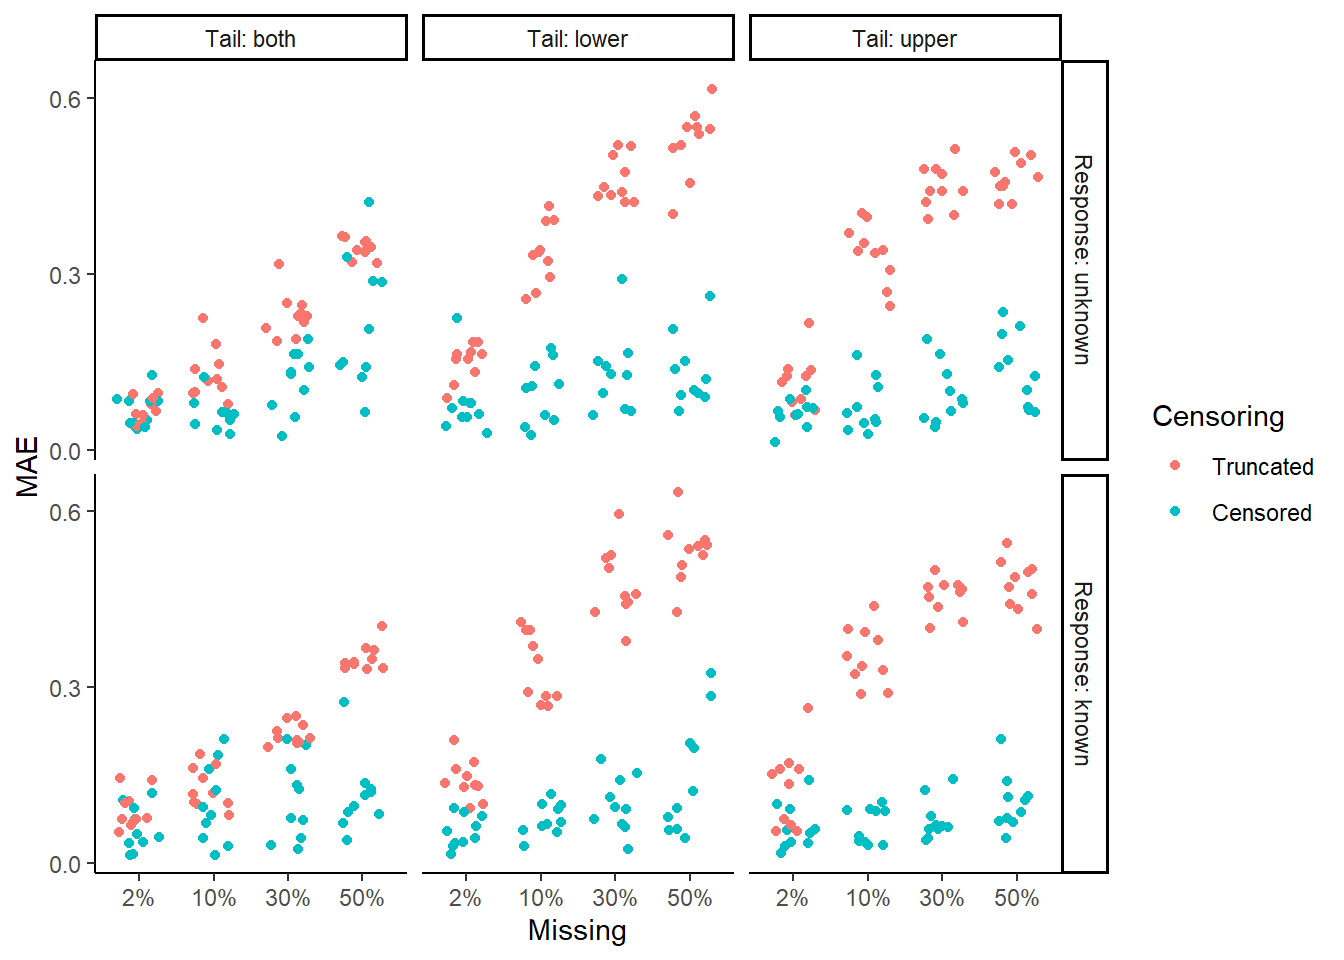

In [ ]:
# w = 0.3
# 
# EMCs_both_MAEs %>%
#   filter(Model == "LNR") %>%
#   summarise(mean = mean(MAE), 
#             MAE_CI = sd(MAE) / sqrt(n()),
#             .by = c(Response, Tail, Missing, Censoring)) %>%
#   ggplot(aes(Missing, mean, color = Censoring, group = Censoring)) +
#   facet_grid(Response ~ Tail,
#              labeller = label_both) +
#   geom_point(position = position_dodge(width = w)) +
#   geom_path(position = position_dodge(width = w)) +
#   geom_errorbar(aes(ymin = mean - MAE_CI, ymax = mean + MAE_CI),
#                 position = position_dodge(width = w),
#                 width = 0.5) +
#   labs(fill = "Missing") +
#   theme_classic() +
#   scale_y_continuous(n.breaks = 3)

EMCs_both_MAEs %>%
  filter(Model == "LNR") %>%
  ggplot(aes(Missing, MAE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

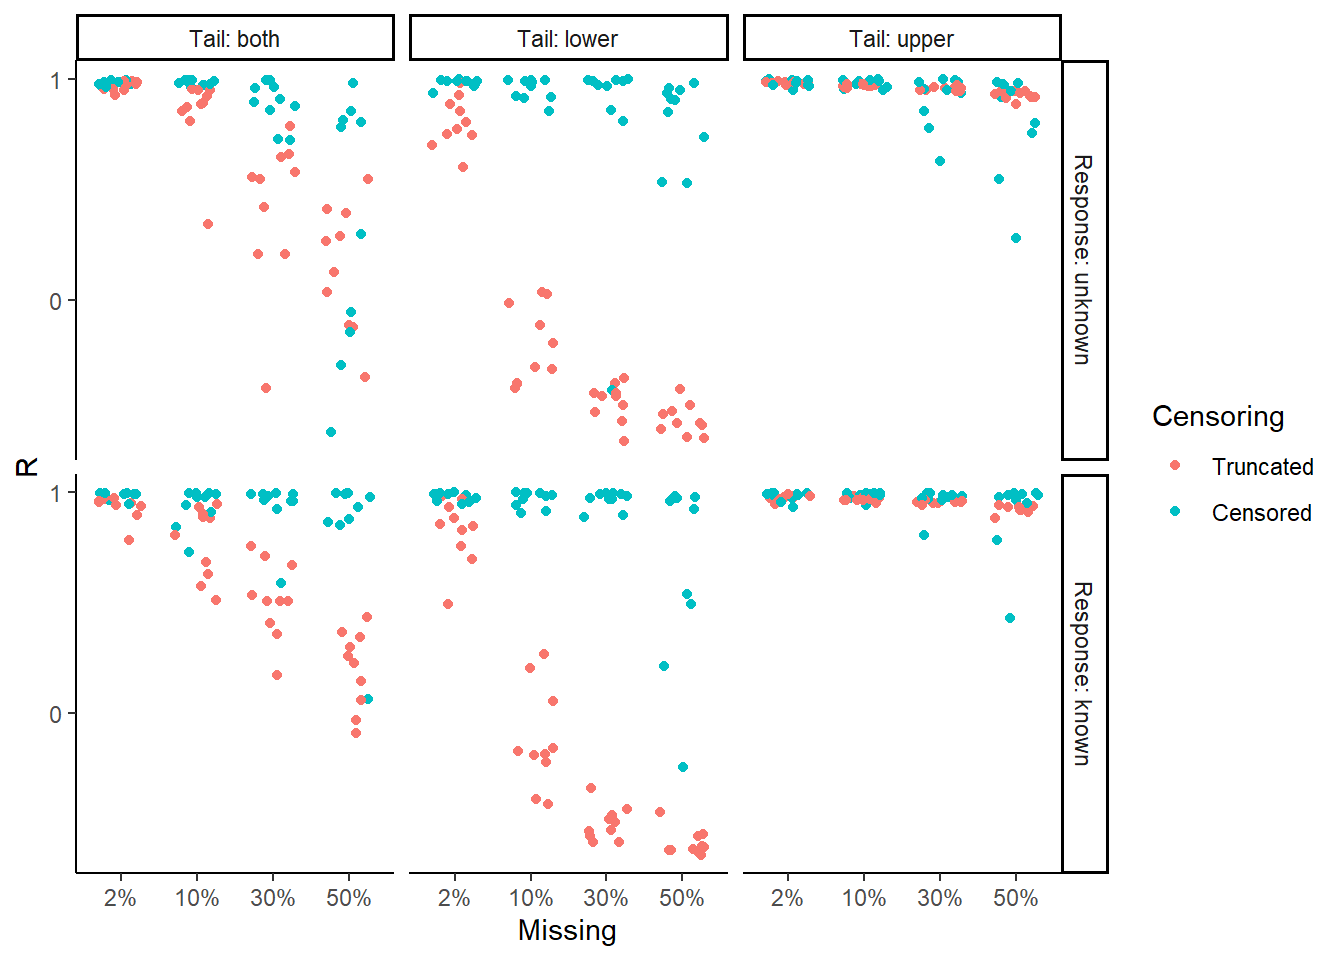

In [ ]:
# w = 0.3
# 
# EMCs_both_Rs %>%
#   filter(Model == "LNR") %>%
#   summarise(mean = mean(R),
#             R_CI = sd(R) / sqrt(n()),
#             .by = c(Response, Tail, Missing, Censoring)) %>%
#   ggplot(aes(Missing, mean, color = Censoring, group = Censoring)) +
#   facet_grid(Response ~ Tail,
#              labeller = label_both) +
#   geom_point(position = position_dodge(width = w)) +
#   geom_path(position = position_dodge(width = w)) +
#   geom_errorbar(aes(ymin = mean - R_CI, ymax = mean + R_CI),
#                 position = position_dodge(width = w),
#                 width = 0.5) +
#   labs(fill = "Missing") +
#   theme_classic() +
#   scale_y_continuous(n.breaks = 3)

EMCs_both_Rs %>%
  filter(Model == "LNR") %>%
  ggplot(aes(Missing, R, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

### Credible Intervals

#### Upper Tail

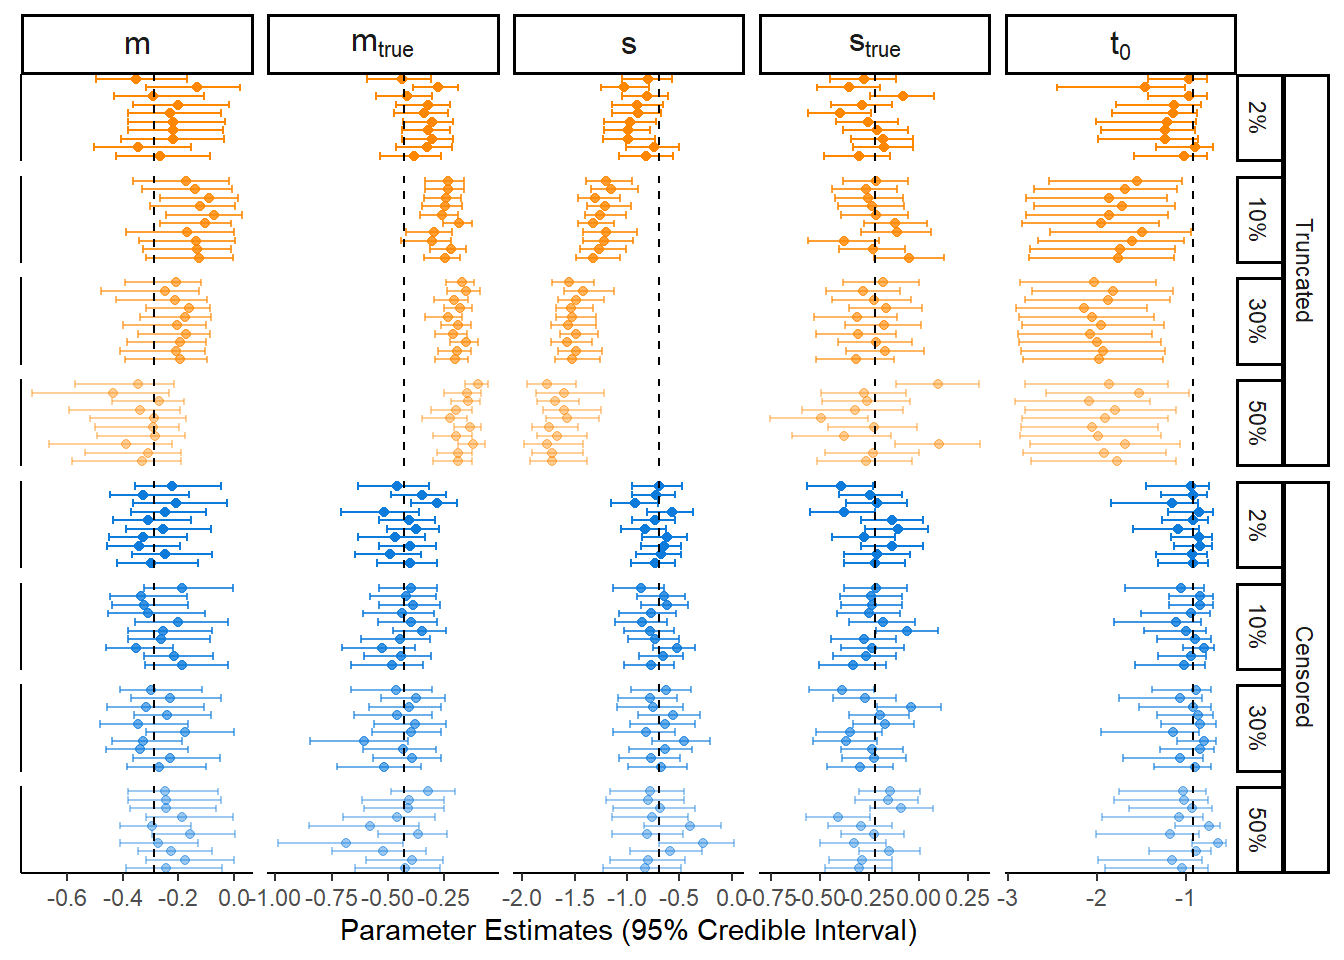

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "upper" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

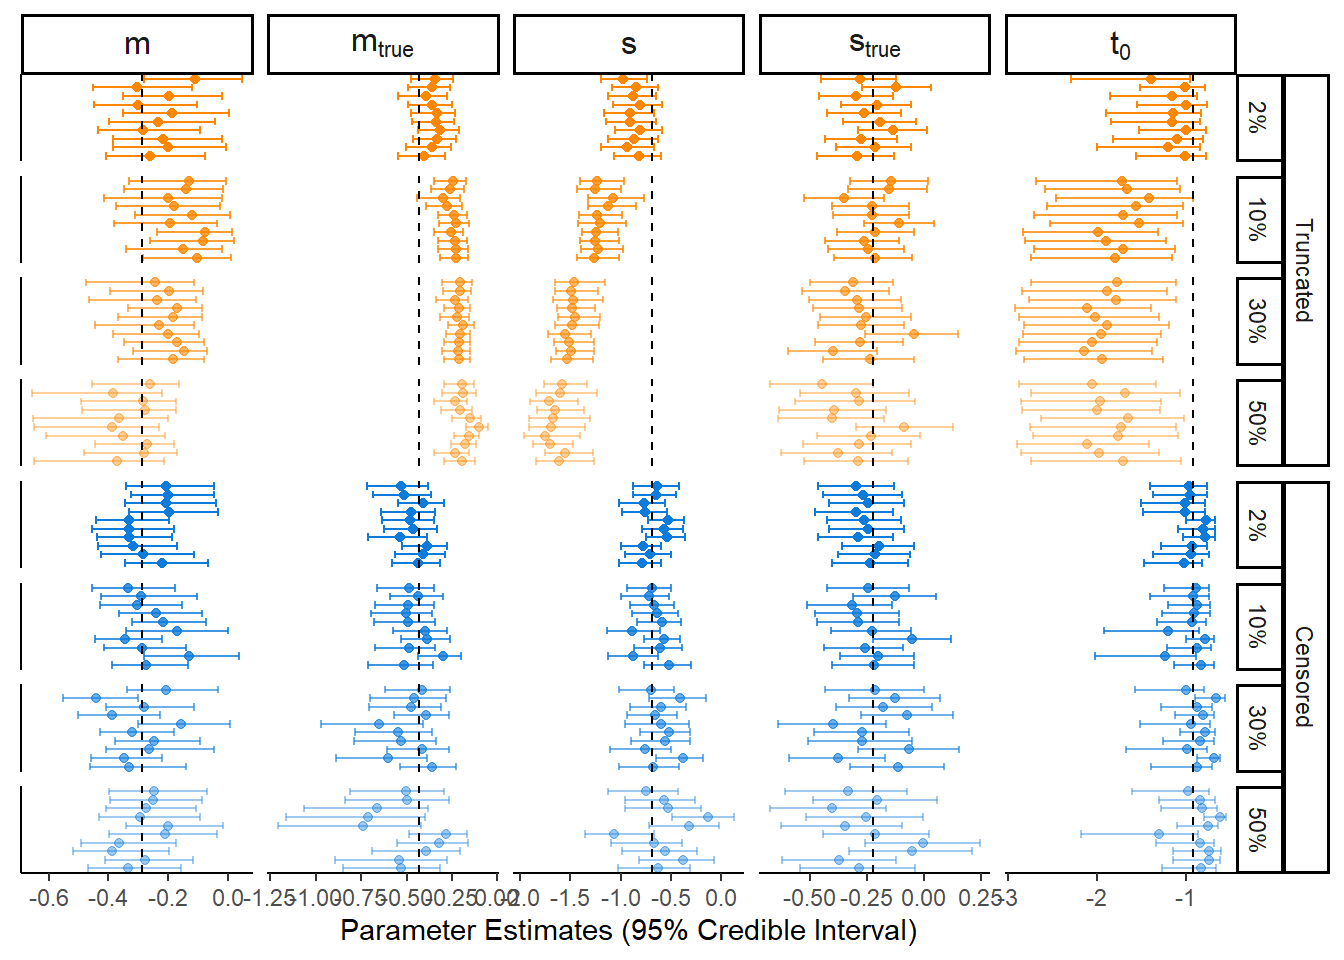

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "upper" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Lower Tail

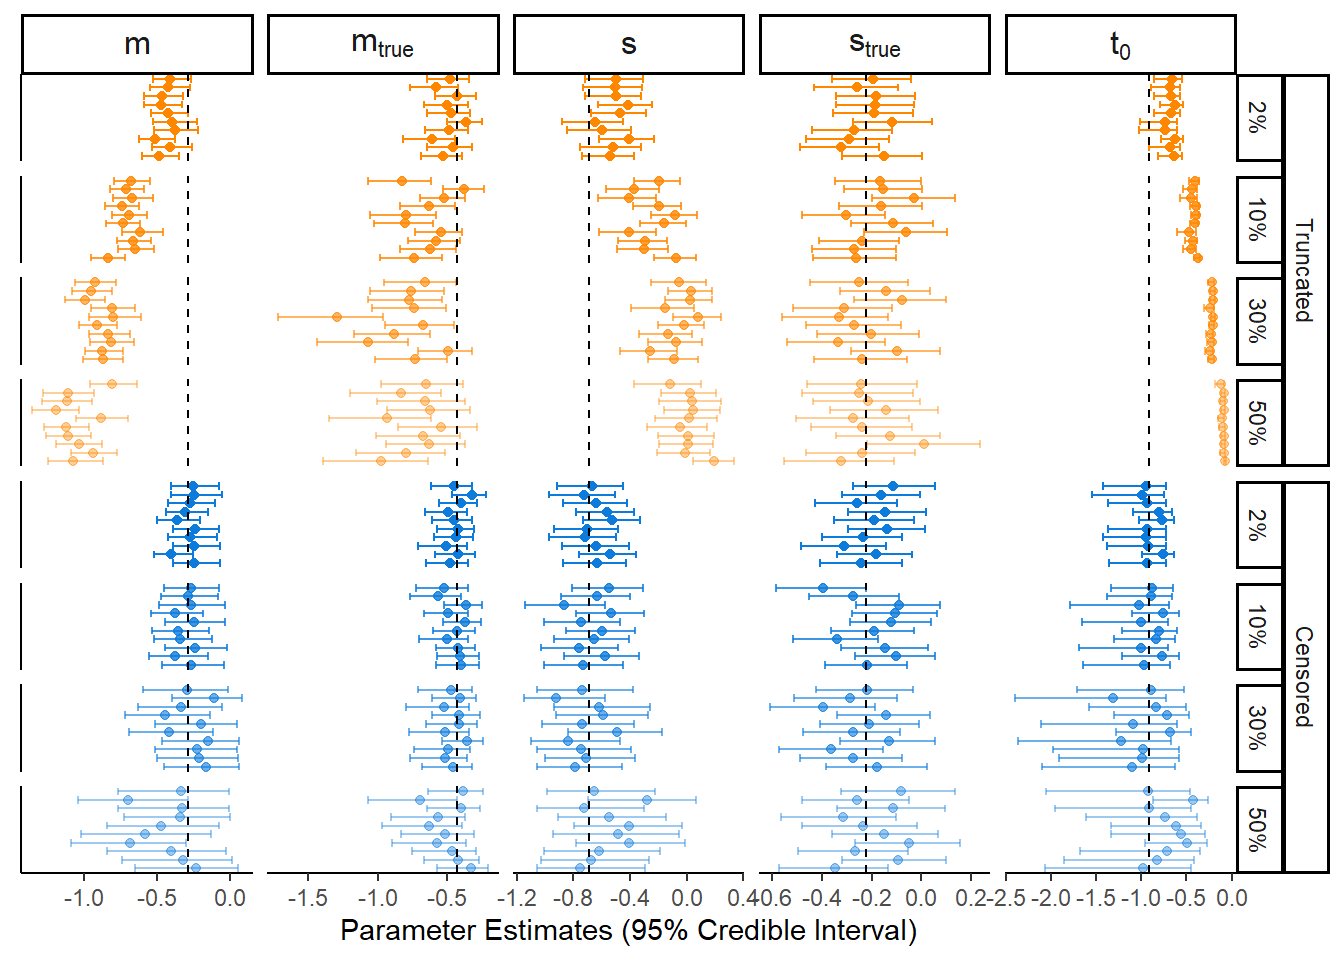

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "lower" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

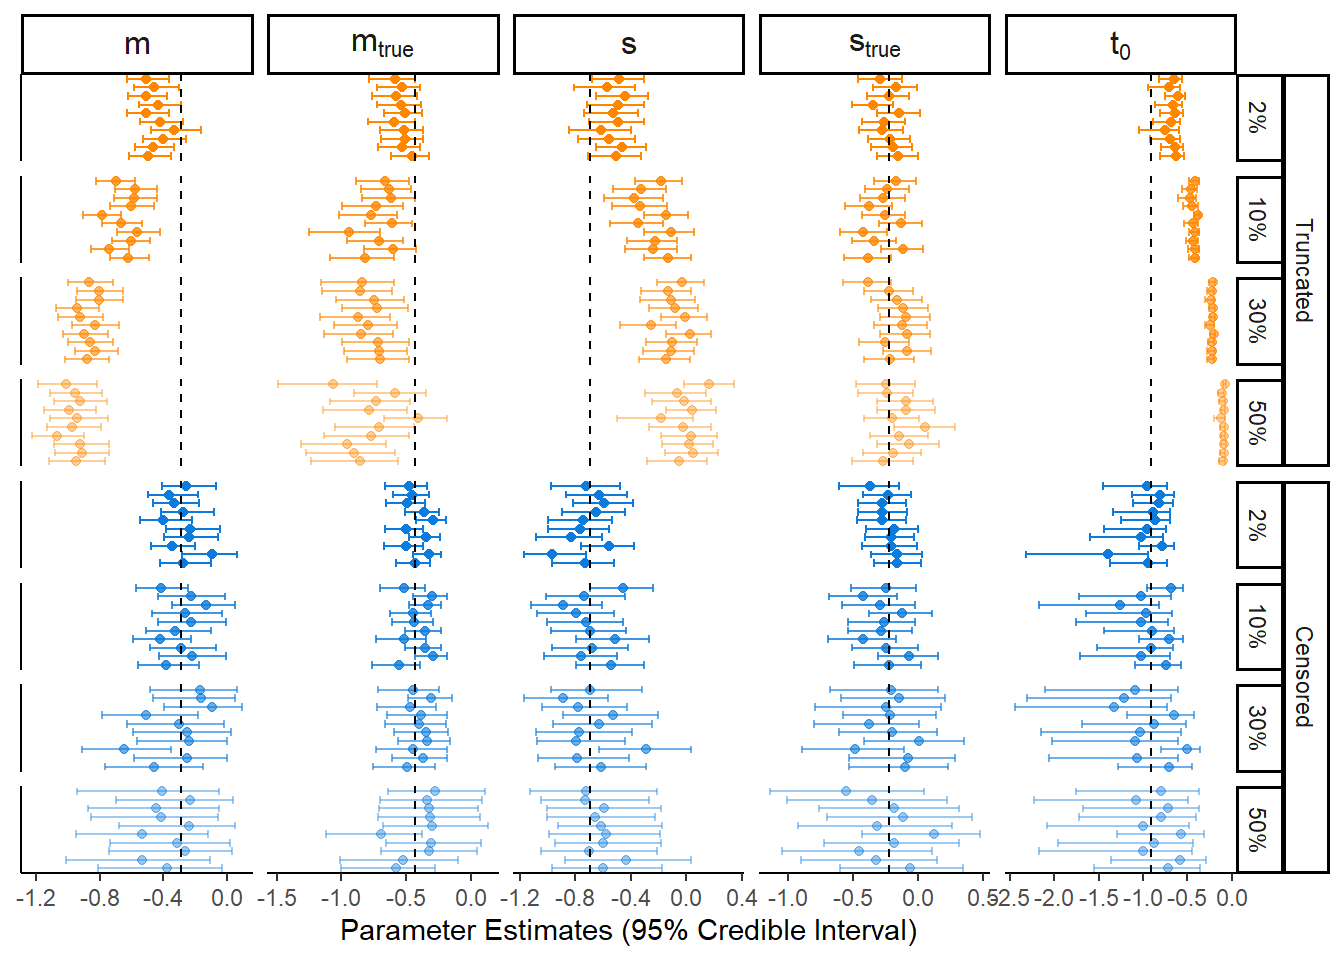

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "lower" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Both Tails

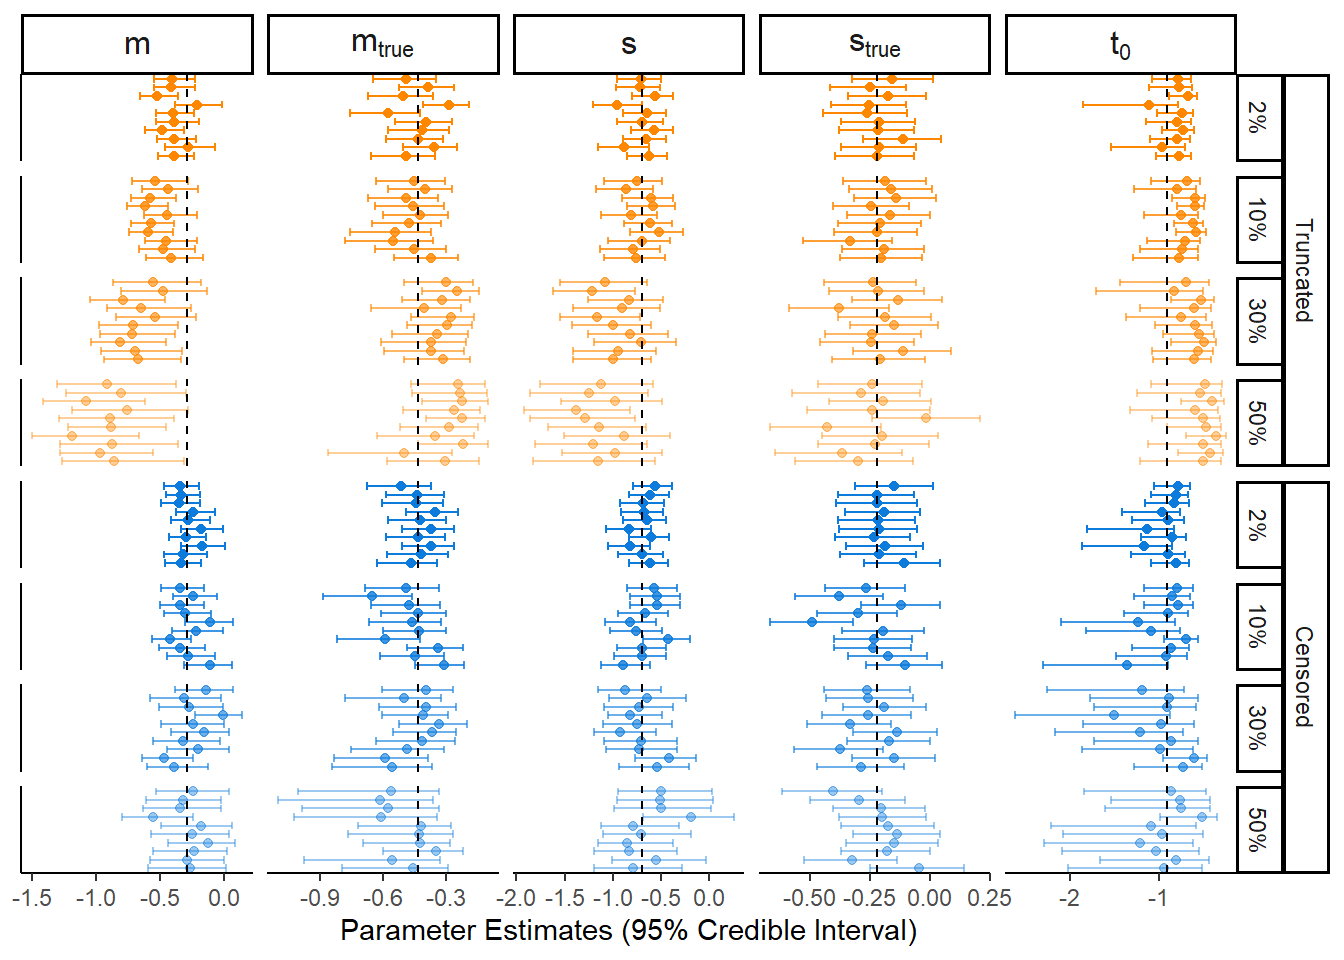

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "both" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

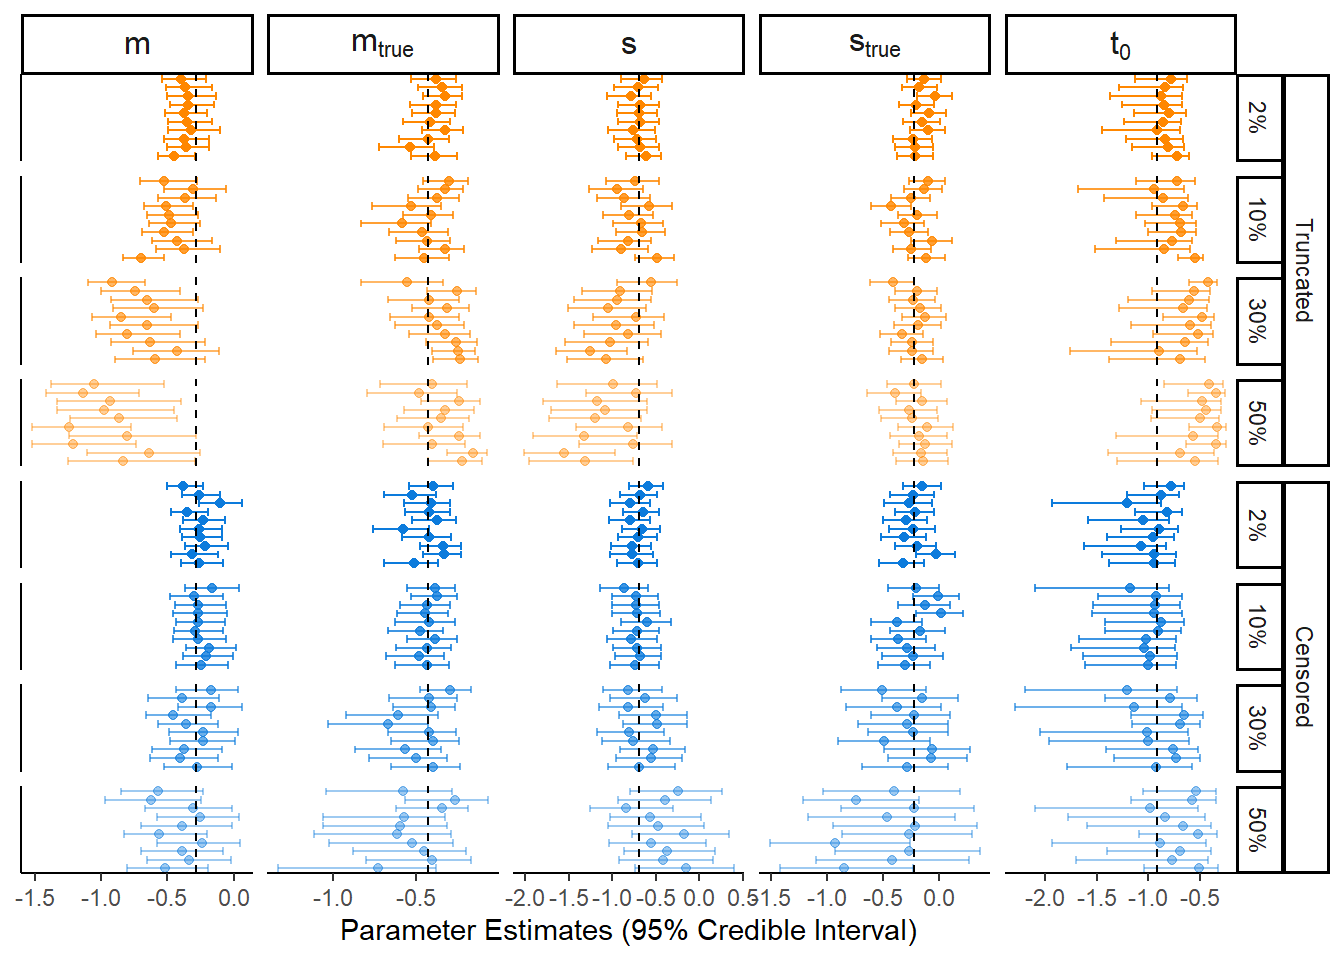

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "LNR" & Tail == "both" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

## Racing Diffusion Model

### Model Distances

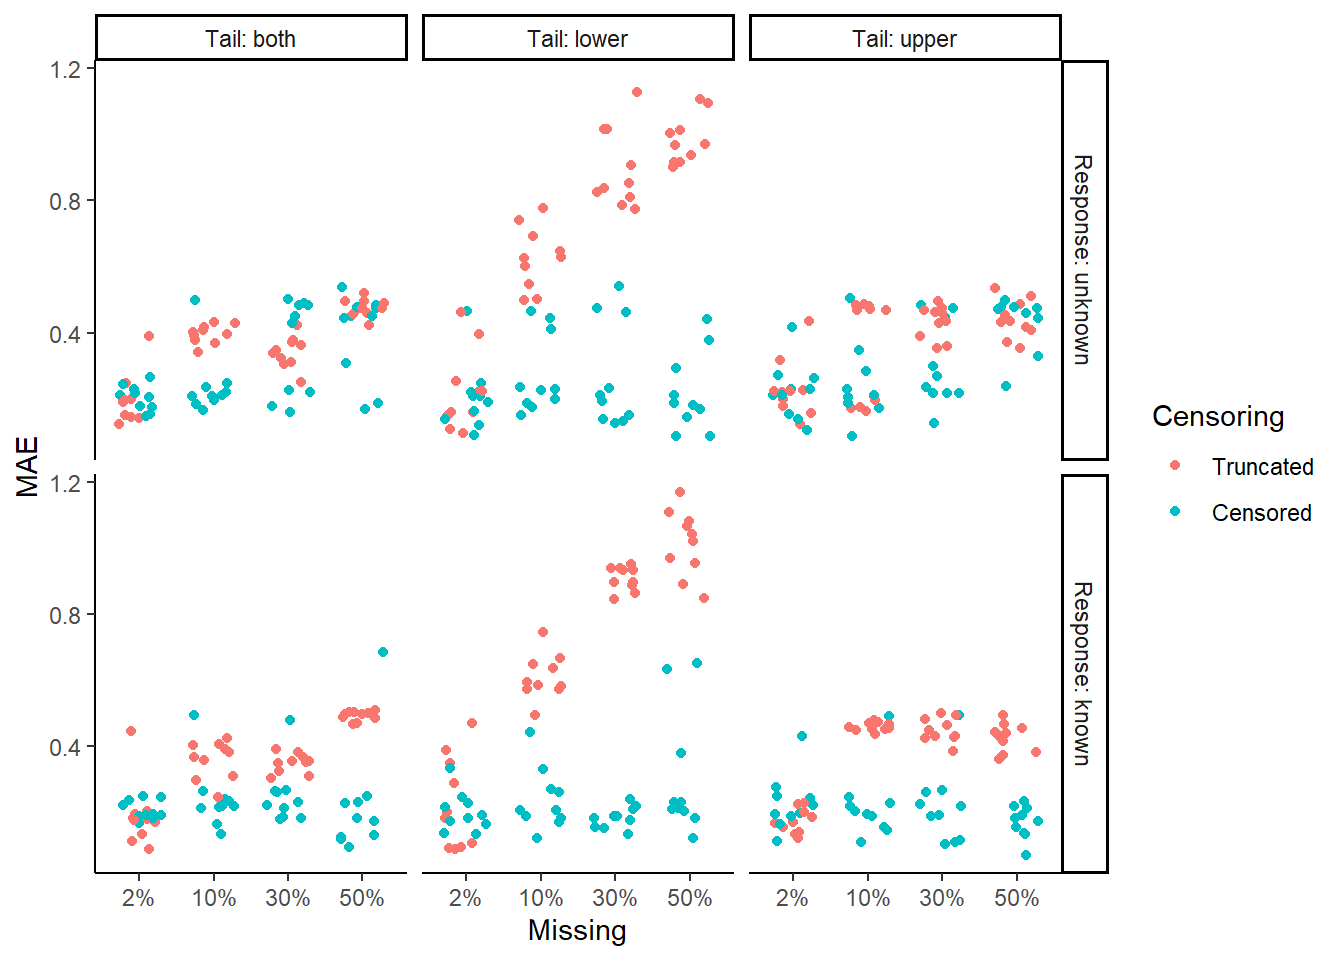

In [ ]:
# w = 0.3
# 
# EMCs_both_MAEs %>%
#   filter(Model == "RDM") %>%
#   summarise(mean = mean(MAE), 
#             MAE_CI = sd(MAE) / sqrt(n()),
#             .by = c(Response, Tail, Missing, Censoring)) %>%
#   ggplot(aes(Missing, mean, color = Censoring, group = Censoring)) +
#   facet_grid(Response ~ Tail,
#              labeller = label_both) +
#   geom_point(position = position_dodge(width = w)) +
#   geom_path(position = position_dodge(width = w)) +
#   geom_errorbar(aes(ymin = mean - MAE_CI, ymax = mean + MAE_CI),
#                 position = position_dodge(width = w),
#                 width = 0.5) +
#   labs(fill = "Missing") +
#   theme_classic() +
#   scale_y_continuous(n.breaks = 3)

EMCs_both_MAEs %>%
  filter(Model == "RDM") %>%
  ggplot(aes(Missing, MAE, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

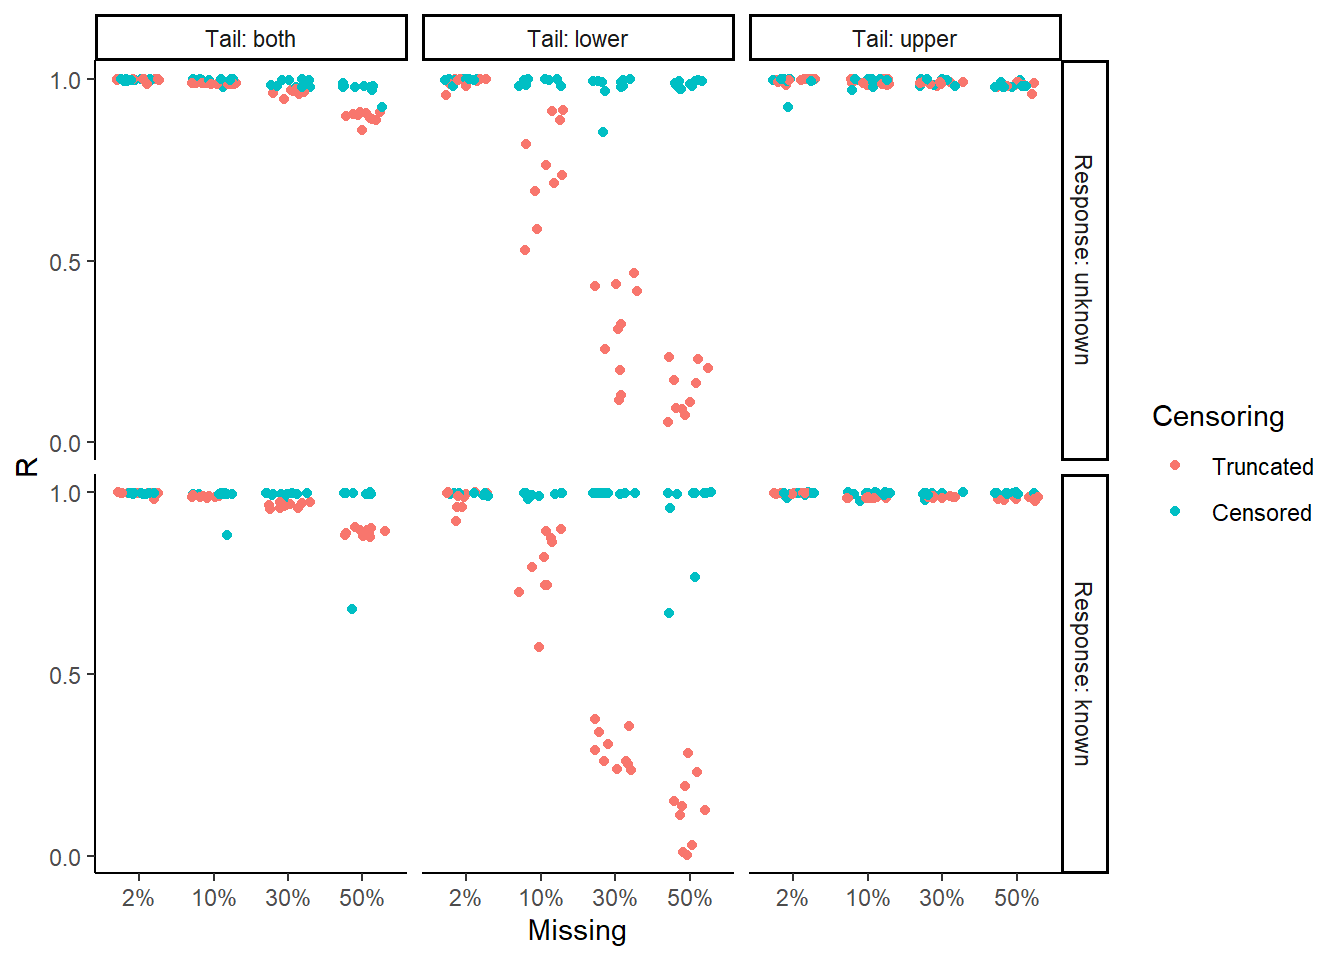

In [ ]:
# w = 0.3
# 
# EMCs_both_Rs %>%
#   filter(Model == "RDM") %>%
#   summarise(mean = mean(R),
#             R_CI = sd(R) / sqrt(n()),
#             .by = c(Response, Tail, Missing, Censoring)) %>%
#   ggplot(aes(Missing, mean, color = Censoring, group = Censoring)) +
#   facet_grid(Response ~ Tail,
#              labeller = label_both) +
#   geom_point(position = position_dodge(width = w)) +
#   geom_path(position = position_dodge(width = w)) +
#   geom_errorbar(aes(ymin = mean - R_CI, ymax = mean + R_CI),
#                 position = position_dodge(width = w),
#                 width = 0.5) +
#   labs(fill = "Missing") +
#   theme_classic() +
#   scale_y_continuous(n.breaks = 3)

EMCs_both_Rs %>%
  filter(Model == "RDM") %>%
  ggplot(aes(Missing, R, color = Censoring, group = Censoring)) +
  facet_grid(Response ~ Tail,
             labeller = label_both) +
  geom_point(position = position_jitter(width = 0.3, height = 0)) +
  labs(fill = "Missing") +
  theme_classic() +
  scale_y_continuous(n.breaks = 3)

### Credible Intervals

#### Upper Tail

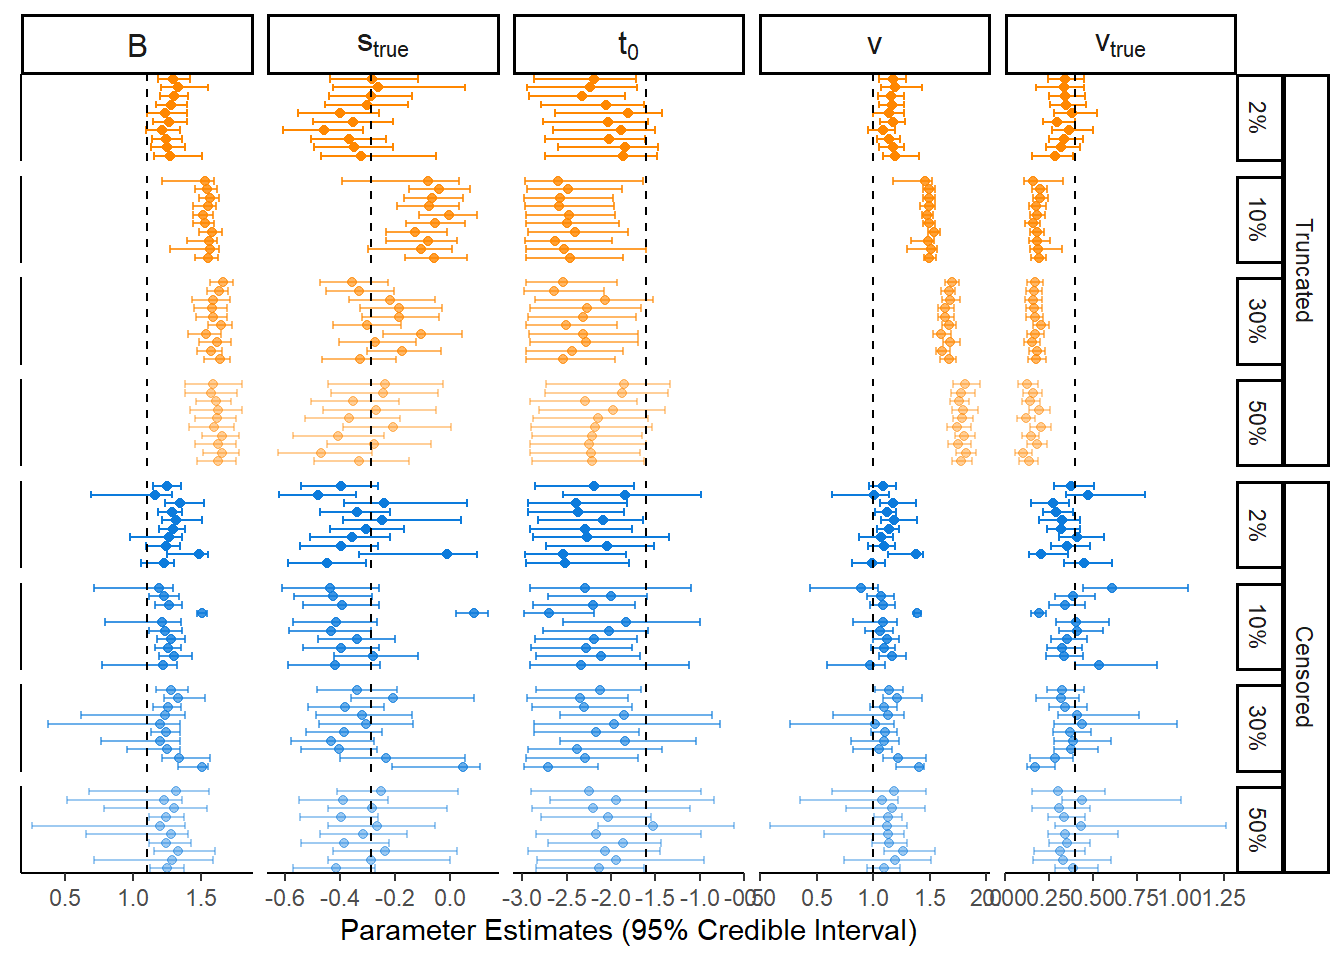

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "upper" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

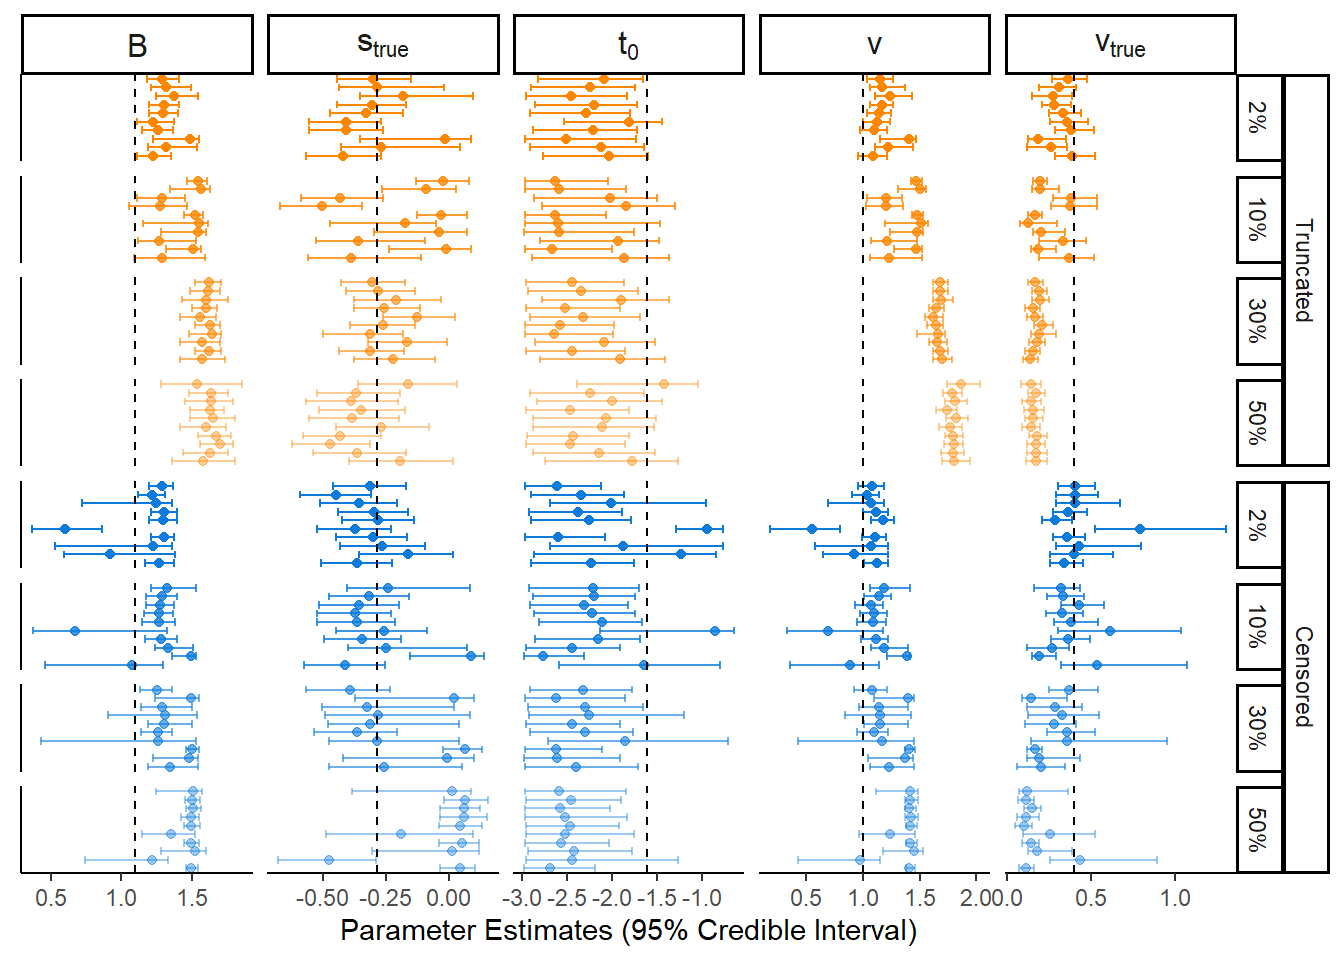

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "upper" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Lower Tail

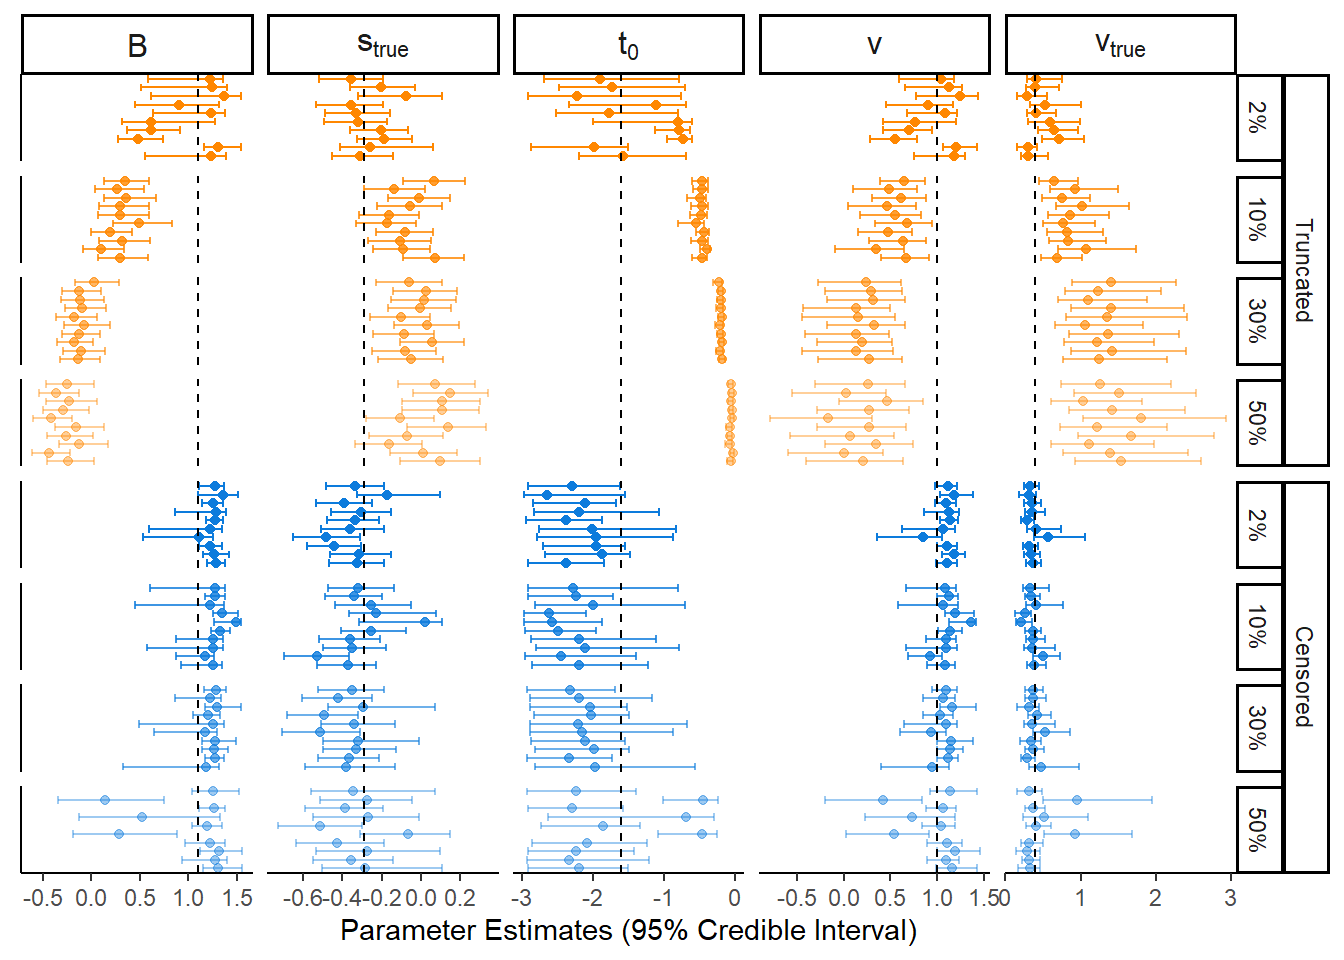

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "lower" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

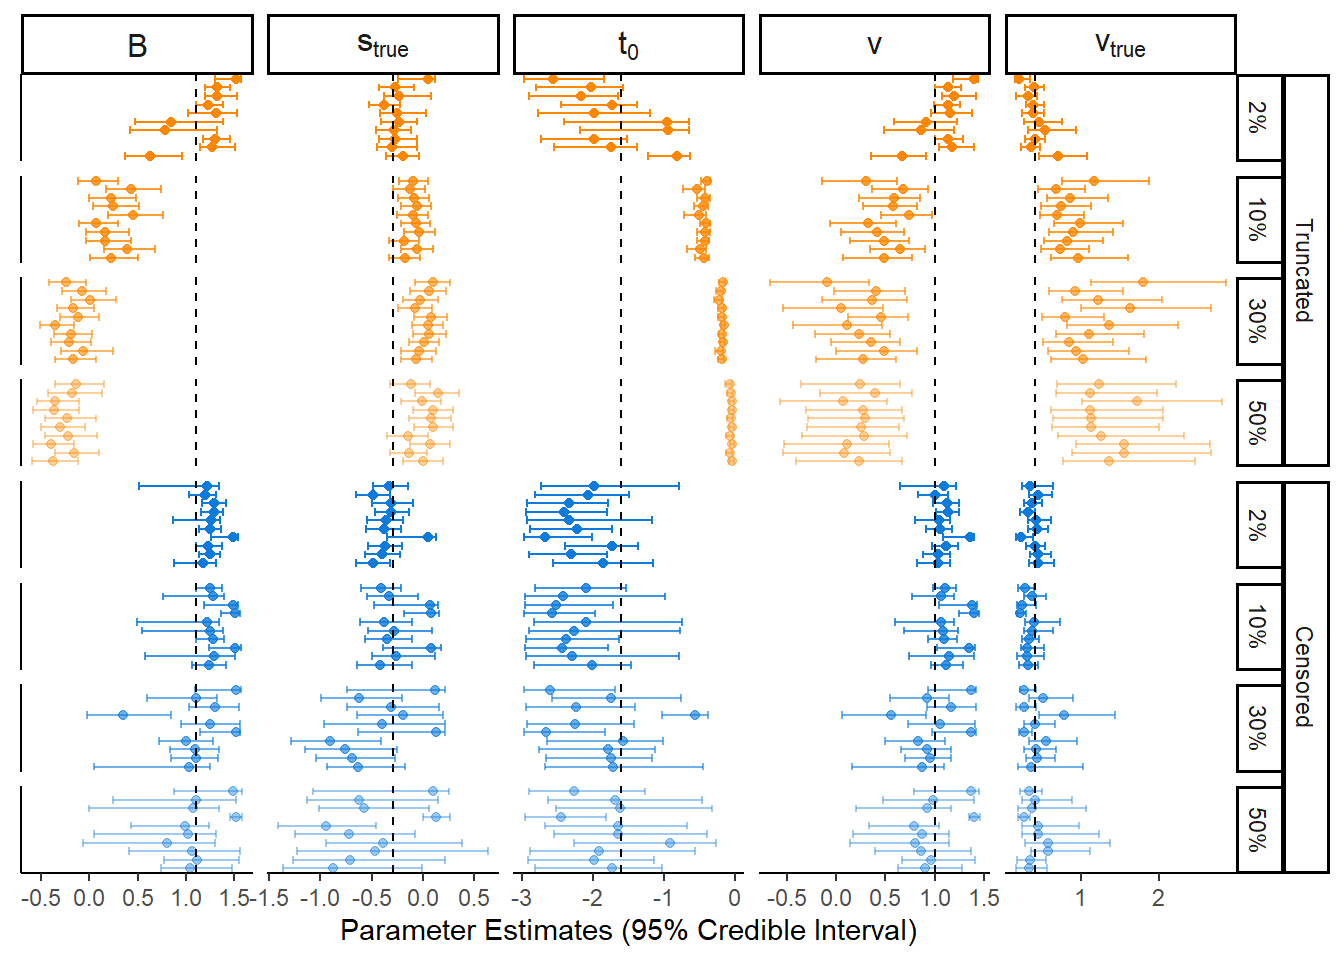

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "lower" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

#### Both Tails

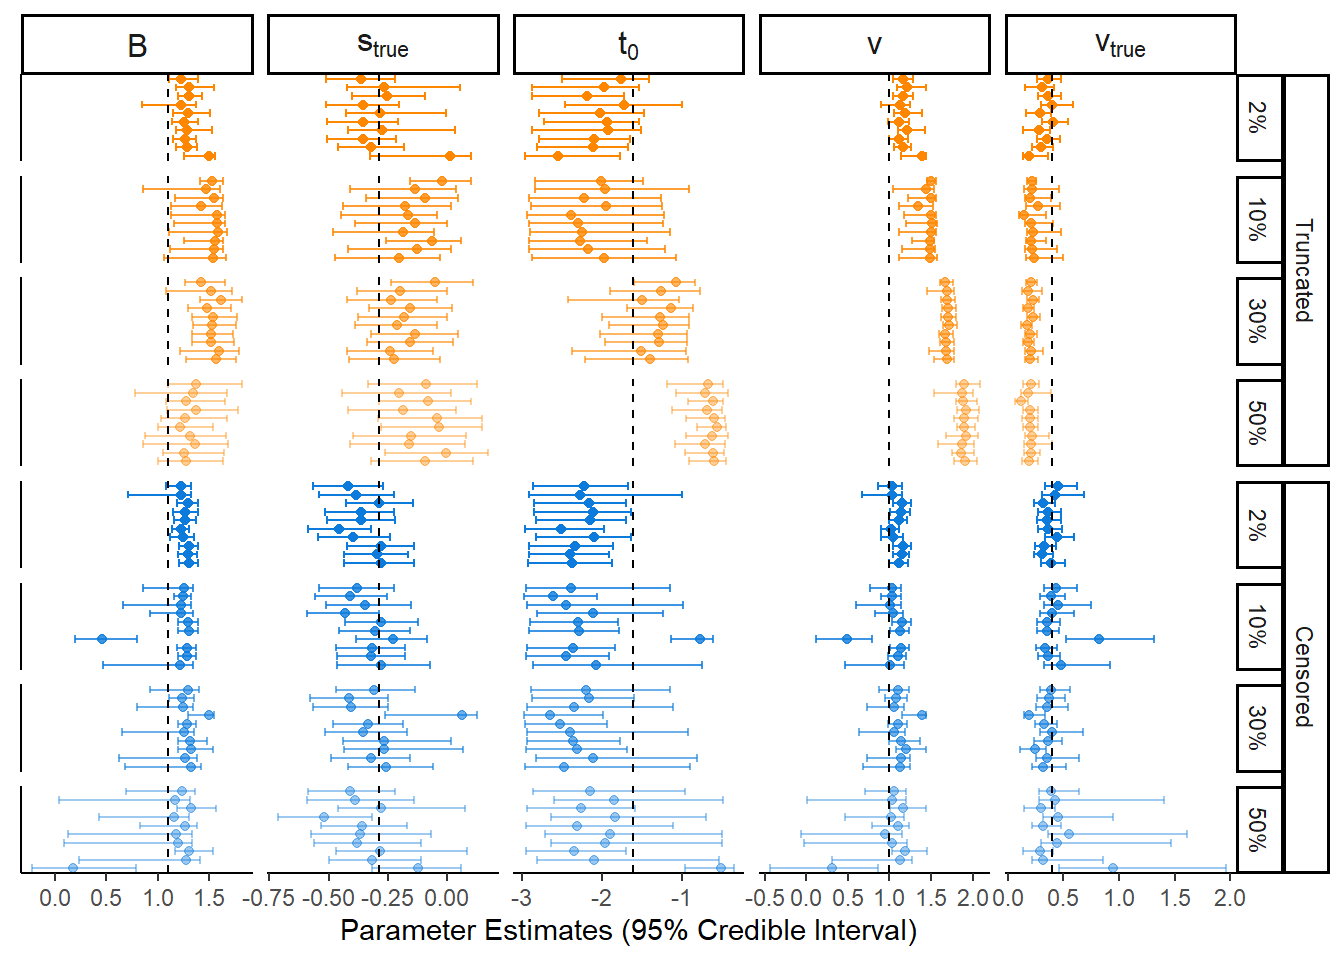

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "both" & Response == "known") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))

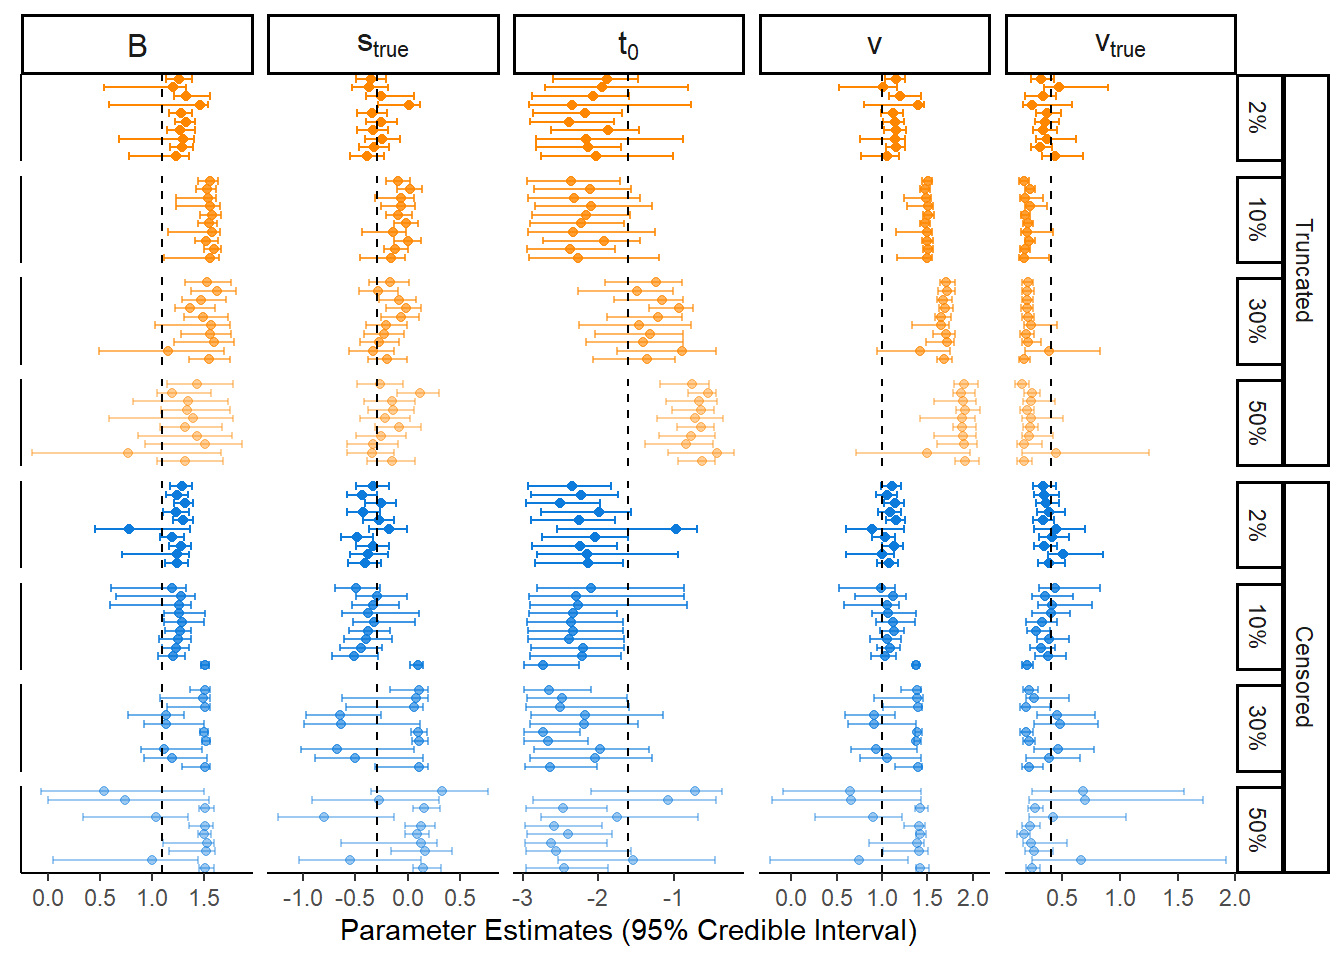

In [ ]:
pars_EMCs_both$id <- as.factor(pars_EMCs_both$id)
pars_EMCs_both %>%
  filter(Model == "RDM" & Tail == "both" & Response == "unknown") %>%
  ggplot(aes(Median, id, color = Censoring, alpha = Missing)) +
  geom_point() +
  facet_nested(Censoring + Missing ~ Variable, scales = "free_x", 
             labeller = labeller(.rows = label_value, Variable = parlabeller, 
                                 .default = label_parsed)) +
  geom_errorbarh(aes(xmin = Q2.5, xmax = Q97.5)) +
  geom_vline(aes(xintercept = True), linetype = "dashed") +
  theme_classic() + 
  xlab("Parameter Estimates (95% Credible Interval)") +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        strip.text.x = element_text(size = 12),
        legend.position = "none") +
  scale_color_manual(values = ct_colors) +
  scale_alpha_ordinal(range = c(1, 0.4))